# Setup

In [21]:
# Standard library imports
import warnings

# Third-party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt, SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose

# Configuration
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.style.use('fivethirtyeight')

This code imports the necessary libraries for time series analysis and visualization in Python.

First, `import warnings` brings in the `warnings` module. This is used to manage warning messages that might appear during code execution.  Often these are informational but can clutter output; we’ll see how it’s used shortly to suppress certain types of warnings.

Next, several third-party libraries are imported:

*   `import matplotlib.pyplot as plt`: `matplotlib` is a powerful plotting library. We import its `pyplot` module and give it the alias `plt`, which is standard practice. This allows us to create charts and graphs easily.
*   `import numpy as np`:  `numpy` provides support for numerical operations, especially with arrays. It's fundamental for many scientific computing tasks in Python. We use the alias `np`.
*   `import pandas as pd`: `pandas` is a library built on top of NumPy that provides data structures like DataFrames, which are excellent for working with tabular data (like time series).  The alias `pd` is standard.
*   `from sklearn.metrics import mean_absolute_error, mean_squared_error`: This imports specific functions from the `sklearn` (scikit-learn) library. These functions (`mean_absolute_error` and `mean_squared_error`) are used to evaluate the accuracy of our time series forecasting models by calculating how close our predictions are to the actual values.
*   `from statsmodels.graphics.tsaplots import plot_acf, plot_pacf`:  `statsmodels` is a library focused on statistical modeling. Here we're importing functions for visualizing *autocorrelation* and *partial autocorrelation*. These plots (`plot_acf`, `plot_pacf`) are crucial tools for understanding the relationships within a time series and choosing appropriate models.
*   `from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt, SimpleExpSmoothing`: This imports classes from `statsmodels` that implement different *exponential smoothing* methods. These are common techniques for forecasting time series data.  `ExponentialSmoothing` is a general class, while `Holt` and `SimpleExpSmoothing` represent specific variations of the technique.
*   `from statsmodels.tsa.seasonal import seasonal_decompose`: This imports a function that allows us to break down a time series into its constituent parts: trend, seasonality, and residual (random noise).  This is helpful for understanding the underlying patterns in the data.

Finally, there are two configuration lines:

*   `warnings.simplefilter(action='ignore', category=FutureWarning)`: This line tells Python to ignore `FutureWarning` messages. These warnings indicate that a feature you're using might be deprecated (removed) in a future version of the library.  While it’s good practice to eventually update your code, ignoring these can keep output cleaner during initial exploration.
*   `plt.style.use('fivethirtyeight')`: This sets the visual style for `matplotlib` plots to 'fivethirtyeight'. This is a pre-defined style that provides a specific look and feel (color scheme, font sizes, etc.) often used in data visualizations.  It's purely aesthetic and doesn’t affect the functionality of the code.

In [22]:
class CFG:
    SEASONAL_PERIOD = 12
    ACF_LAGS = 12
    data_folder = './data/'
    img_dim1 = 20
    img_dim2 = 10
    SEED = 42

# display style 
plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (CFG.img_dim1, CFG.img_dim2)


np.random.seed(CFG.SEED)

This code defines a configuration class and sets up some display settings for plotting. 

First, the `class CFG:` block creates a class named `CFG`. This is a common practice in Python to group related constants or parameters together. Think of it as a container for settings that will be used throughout your program. Inside this class:

*   `SEASONAL_PERIOD = 12`:  This defines a constant representing the length of the seasonal cycle in your time series data. A value of 12 suggests monthly seasonality (like yearly patterns repeating every 12 months).
*   `ACF_LAGS = 12`: This sets the number of lags to consider when calculating the Autocorrelation Function (ACF). The ACF helps identify how strongly past values are correlated with current values in a time series.  Using 12 lags means we'll look at correlations up to 12 time periods into the past.
*   `data_folder = './data/'`: This specifies the path to the directory where your time series data is stored. The `./` indicates the current working directory, so it’s looking for a folder named “data” within the same location as your Python script.
*   `img_dim1 = 20` and `img_dim2 = 10`: These define the dimensions (width and height) of the plots you'll be creating using `matplotlib`.  
*   `SEED = 42`: This sets a seed for the random number generator. Setting a seed ensures that any random processes in your code (like data shuffling or initialization) will produce the same results every time you run it.  This is important for reproducibility – meaning others can verify your work. The value 42 is often used as a default, but any integer will work.

Following the class definition:

*   `plt.style.use("seaborn-v0_8")`: This line changes the visual style of `matplotlib` plots to "seaborn-v0_8". Seaborn is another Python visualization library that builds on top of Matplotlib and provides a more aesthetically pleasing default style.  The “v0\_8” specifies a particular version of the seaborn style.
*   `plt.rcParams["figure.figsize"] = (CFG.img_dim1, CFG.img_dim2)`: This line sets the default size of all figures created with `matplotlib`. It uses the values defined in the `CFG` class for the width (`img_dim1`) and height (`img_dim2`).  `plt.rcParams` is a dictionary-like object that controls various aspects of Matplotlib's behavior.
*   `np.random.seed(CFG.SEED)`: This sets the seed for NumPy’s random number generator, using the value defined in the `CFG` class (`SEED`).  As mentioned earlier, this ensures reproducibility of any random operations performed with NumPy.

# Utils

In [23]:
def forecast_metrics(y_true, y_pred):
    return {
        "MAE": float(round(mean_absolute_error(y_true, y_pred), 2)),
        "RMSE": float(round(np.sqrt(mean_squared_error(y_true, y_pred)), 2)),
    }

This function `forecast_metrics` calculates and returns common error metrics used to evaluate the accuracy of time series forecasts. It's very similar to a previous version, but with added formatting for cleaner output.  

*   `def forecast_metrics(y_true, y_pred):`: This defines a function named `forecast_metrics` that takes two arguments:
    *   `y_true`:  This represents the actual (observed) values of your time series. It's typically a NumPy array or Pandas Series.
    *   `y_pred`: This represents the predicted values generated by your forecasting model. It should have the same length as `y_true`.

*   `return { ... }`: The function returns a dictionary containing the calculated error metrics. Dictionaries are useful for storing key-value pairs, making it easy to access specific metrics by their names.

*   `"MAE": float(round(mean_absolute_error(y_true, y_pred), 2)),`: This calculates the Mean Absolute Error (MAE).
    *   `mean_absolute_error(y_true, y_pred)`:  This function from `sklearn.metrics` computes the average absolute difference between the true values (`y_true`) and the predicted values (`y_pred`). MAE gives equal weight to all errors.
    *   `round(..., 2)`: This rounds the result of `mean_absolute_error` to two decimal places, improving readability.
    *   `float(...)`: Converts the rounded value to a floating-point number.  This ensures consistent data type in the dictionary.
    *   `"MAE": ...`: This assigns the calculated and formatted MAE value to the key "MAE" in the dictionary.

*   `"RMSE": float(round(np.sqrt(mean_squared_error(y_true, y_pred)), 2)),`:  This calculates the Root Mean Squared Error (RMSE).
    *   `mean_squared_error(y_true, y_pred)`: This function from `sklearn.metrics` computes the average squared difference between the true and predicted values.
    *   `np.sqrt(...)`: Calculates the square root of the mean squared error to obtain the RMSE.
    *   `round(..., 2)`: This rounds the result to two decimal places, improving readability.
    *   `float(...)`: Converts the rounded value to a floating-point number.
    *   `"RMSE": ...`: This assigns the calculated and formatted RMSE value to the key "RMSE" in the dictionary.

In [24]:
def train_valid_split(df, split_date, value_col="value"):
    train = df.loc[:split_date].copy()
    valid = df.loc[split_date:].copy()
    return train, valid

This is a utility function for dividing your time series data into training and validation sets. 

*   `def train_valid_split(df, split_date, value_col="value"):`: This defines a function named `train_valid_split` that takes three arguments:
    *   `df`: The input DataFrame containing your time series data. It's assumed to have a datetime index (meaning the rows are indexed by dates).
    *   `split_date`: A date string or datetime object that determines where to split the data. All data *up to and including* this date will be used for training, and all data *after* this date will be used for validation.
    *   `value_col="value"`:  Specifies the name of the column in your DataFrame that contains the time series values you want to split. It defaults to "value", but you can change it if your column has a different name.

*   `train = df.loc[:split_date].copy()`: This line creates the training set.
    *   `df.loc[:split_date]` selects all rows from the DataFrame `df` where the index (the date) is less than or equal to `split_date`.  The `:` before `split_date` means "from the beginning of the DataFrame up to and including this date".
    *   `.copy()` creates a new DataFrame that is a copy of the selected data. This prevents modifications to the training set from accidentally affecting the original DataFrame or the validation set.

*   `valid = df.loc[split_date:].copy()`:  This line creates the validation set.
    *   `df.loc[split_date:]` selects all rows from the DataFrame `df` where the index (the date) is greater than or equal to `split_date`. The `:` after `split_date` means "from this date to the end of the DataFrame".
    *   `.copy()` again creates a new, independent copy of the selected data.

*   `return train, valid`:  The function returns two DataFrames: `train` (containing the training data) and `valid` (containing the validation data).

# Exponential smoothing

## Single ES

In [25]:
def plot_ses_smoothing(series_df, alpha, horizon, value_col="series"):
    ses_model = SimpleExpSmoothing(series_df[value_col])
    ses_fit = ses_model.fit(  smoothing_level=alpha, optimized=False)

    forecast = ses_fit.forecast(horizon)
    plt.figure()

    # Original series
    series_df[value_col].plot( label="Observed", linewidth=2, )
    # Smoothed (fitted) values
    ses_fit.fittedvalues.plot( label=f"Smoothed (α={alpha})", linewidth=2 , color = "red"   )
    # Forecast
    forecast.plot( label="Forecast", marker="o", linestyle="--", color="green" )
    
    plt.legend()
    plt.show()


This helper function `plot_ses_smoothing` visualizes the results of applying Simple Exponential Smoothing (SES) to a time series, including both the smoothed values and forecasts. It’s designed to help you understand how SES works and assess its performance on your data.


*   `def plot_ses_smoothing(series_df, alpha, horizon, value_col="series"):`: This defines a function named `plot_ses_smoothing` that takes four arguments:
    *   `series_df`: A Pandas DataFrame containing your time series data. It's expected to have a column with the time series values.
    *   `alpha`: The smoothing level for SES, controlling how much weight is given to recent observations.
    *   `horizon`:  The number of periods into the future you want to forecast. This determines the length of the forecast horizon.
    *   `value_col="series"`: Specifies the name of the column in `series_df` that contains the time series values. It defaults to "series" but can be changed if your data uses a different column name.

*   `ses_model = SimpleExpSmoothing(series_df[value_col])`: This creates an instance of the `SimpleExpSmoothing` class, initializing it with the time series data from the specified column in the DataFrame.

*   `ses_fit = ses_model.fit(  smoothing_level=alpha, optimized=False)`: This fits (trains) the SES model to the data using the provided smoothing level (`alpha`). `optimized=False` prevents the model from automatically searching for the best alpha value; we're explicitly setting it.

*   `forecast = ses_fit.forecast(horizon)`:  This generates a forecast for the specified `horizon` (number of periods into the future) using the fitted SES model.

*   `plt.figure()`: This creates a new Matplotlib figure, which will contain the plot.

*   `series_df[value_col].plot( label="Observed", linewidth=2, )`:  This plots the original time series data as a line, with a width of 2. The `label="Observed"` assigns a label to this line for use in the legend.

*   `ses_fit.fittedvalues.plot( label=f"Smoothed (α={alpha})", linewidth=2 , color = "red"   )`: This plots the smoothed values generated by the SES model (the *in-sample fitted values*) as a line with a line width of 2 and red color. The `label` dynamically includes the value of `alpha` used for smoothing, making it clear which smoothing level was applied.  Using red helps visually distinguish the smoothed line from the original data.

*   `forecast.plot( label="Forecast", marker="o", linestyle="--", color="green" )`: This plots the forecasted values as a dashed line (`linestyle="--"`) with circular markers (`marker="o"`), and a green color. The `label="Forecast"` assigns a label for the legend.  The green color differentiates the forecast from both the observed data and the smoothed curve.

*   `plt.legend()`:  This displays the legend on the plot, showing the labels assigned to each line (Observed, Smoothed, Forecast). The different colors will be represented in the legend as well.

*   `plt.show()`: This displays the generated plot.

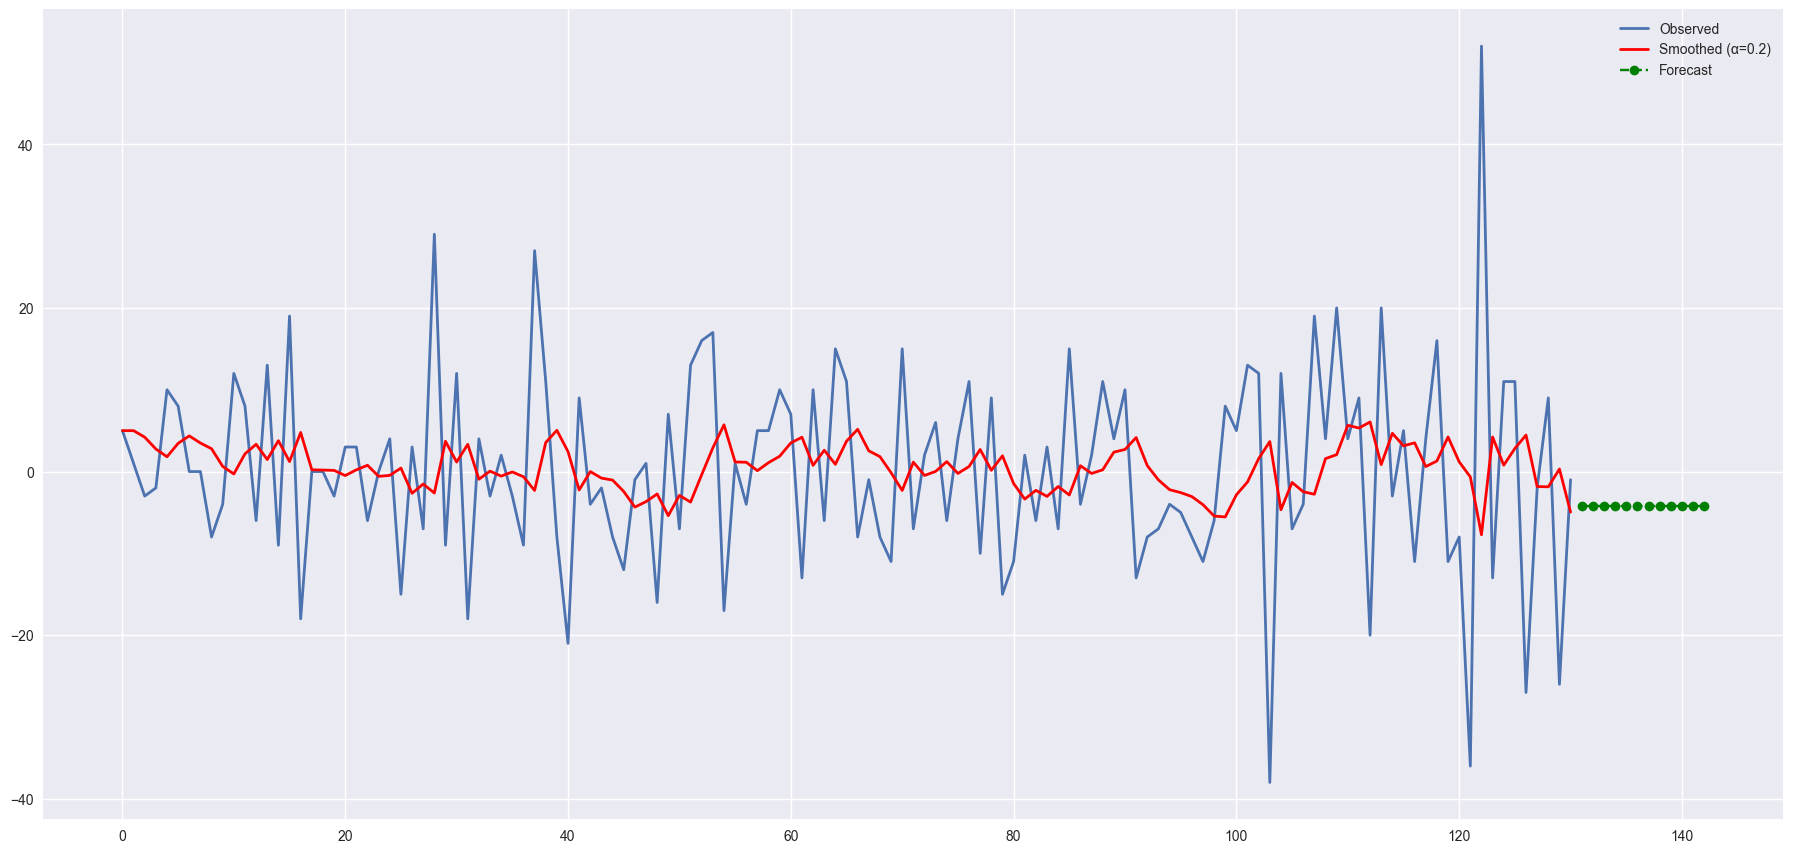

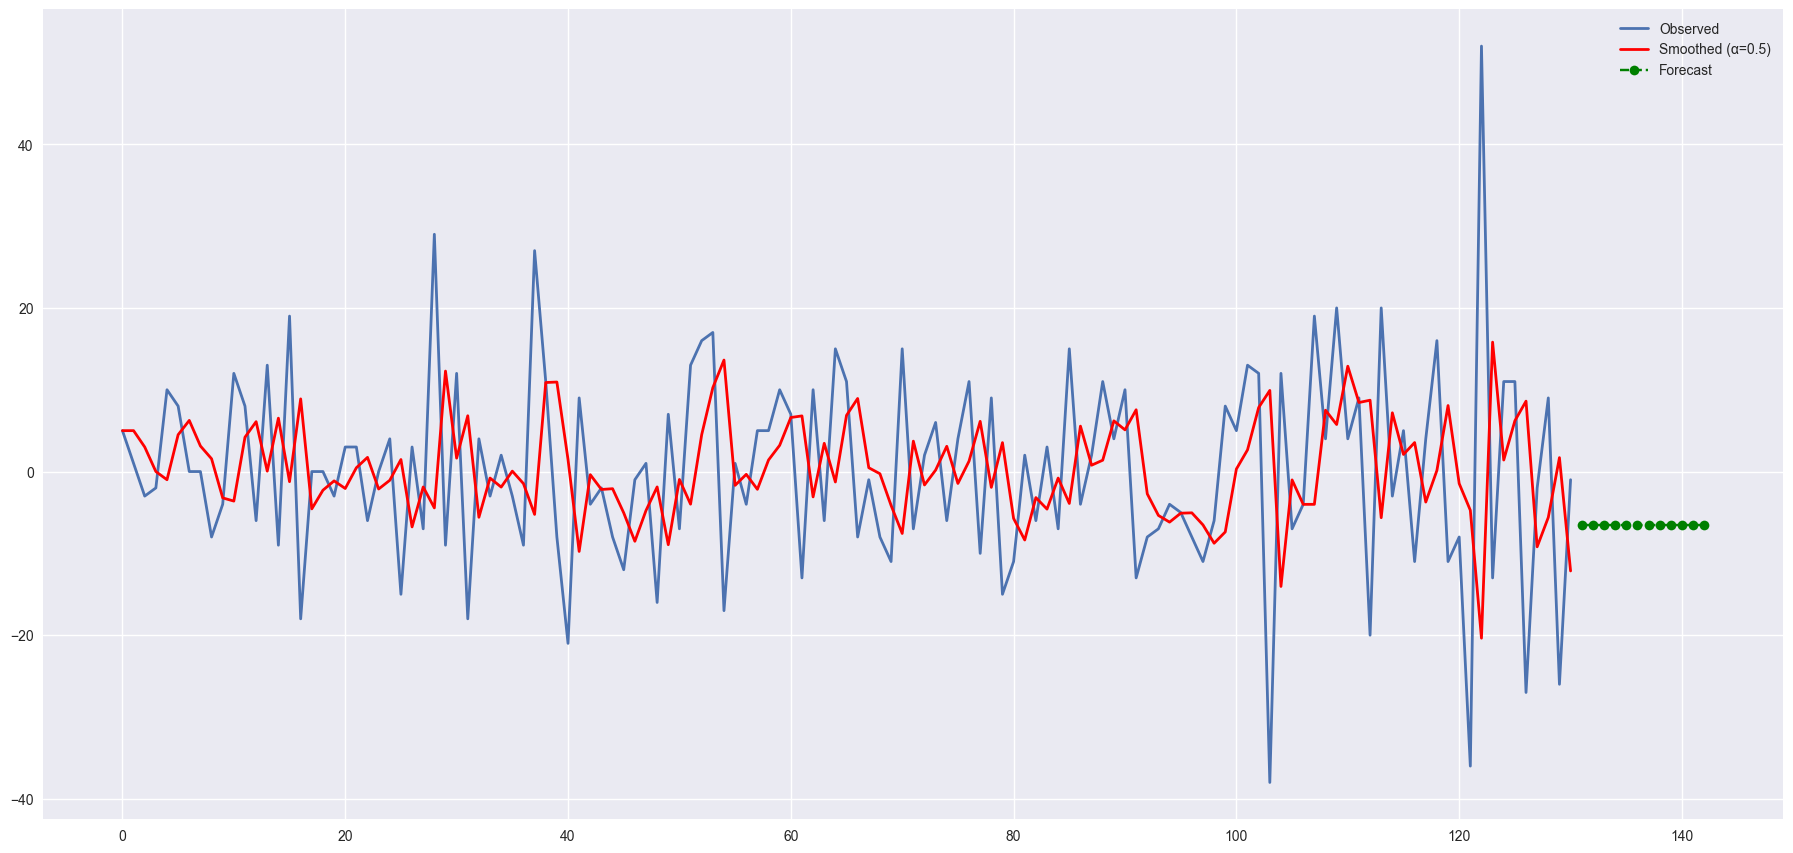

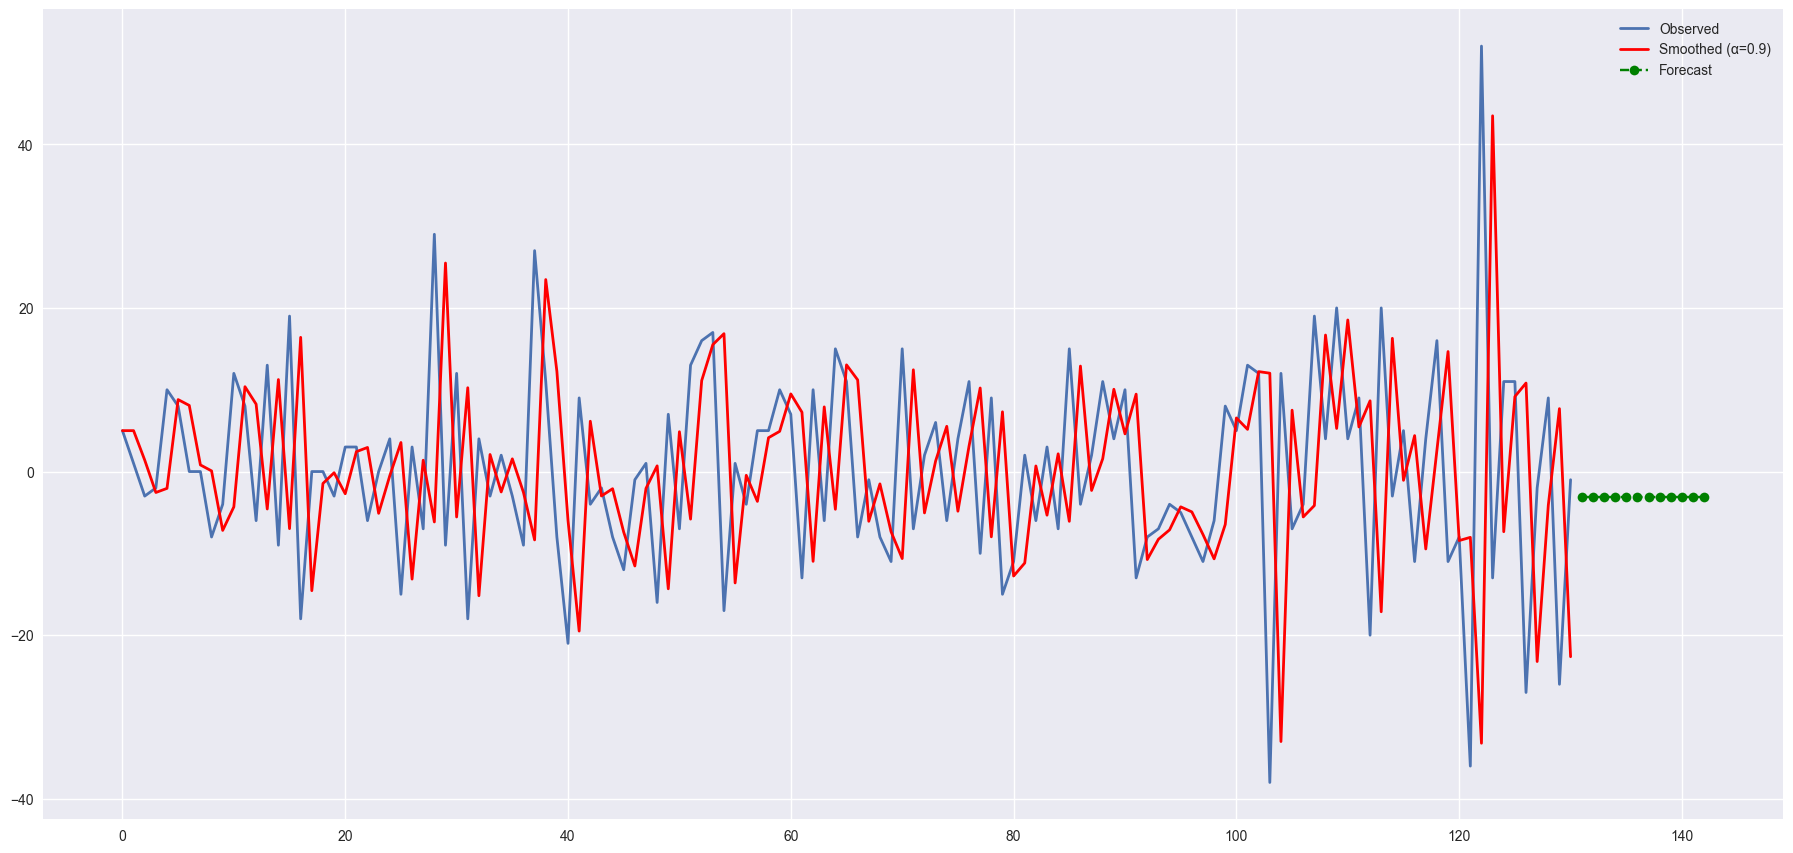

In [26]:
HORIZON = 12
ALPHAS = [0.2, 0.5, 0.9]

series_df = pd.read_csv(
    CFG.data_folder + "exp1.csv",
    header=None,names=["series"],
)

for alpha in ALPHAS:
    plot_ses_smoothing(series_df, alpha=alpha, horizon=HORIZON)

This code demonstrates the application of Simple Exponential Smoothing (SES) with different smoothing levels (`alpha`). 

*   `df = pd.read_csv(CFG.data_folder + 'exp1.csv', header = None); df.columns = ['series']`: This line reads data from a CSV file named "exp1.csv" located in the directory specified by `CFG.data_folder`.
    *   `pd.read_csv(...)`:  This is the Pandas function for reading data from a comma-separated value (CSV) file.
    *   `header = None`: This argument tells `read_csv` that the CSV file does *not* have a header row containing column names.
    *   `df.columns = ['series']`:  After reading the data, this line assigns the name "series" to the single column in the DataFrame.

*   `# synthetic data demonstration`: This is just a comment indicating that the following code demonstrates SES on some example (likely synthetic) time series data.

*   `for alpha_sm in [0.2 , 0.5, 0.9]:`:  This starts a loop that iterates through three different values for the smoothing level (`alpha_sm`): 0.2, 0.5, and 0.9. The smoothing level controls how much weight is given to recent observations versus past observations in the SES model.

*   `df.plot.line()`: This plots the original time series data as a line plot using Pandas' built-in plotting functionality.  This provides a visual baseline for comparison with the smoothed and forecasted values.

*   `fit1 = SimpleExpSmoothing(df).fit(smoothing_level = alpha_sm  ,optimized=False)`: This is where the SES model is fitted to the data.
    *   `SimpleExpSmoothing(df)`: Creates an instance of the `SimpleExpSmoothing` class from the `statsmodels` library, initializing it with your time series data (`df`).
    *   `.fit(smoothing_level = alpha_sm  ,optimized=False)`: This fits (trains) the SES model to the data.
        *   `smoothing_level = alpha_sm`: Sets the smoothing level for this particular iteration of the loop.
        *   `optimized=False`:  This is important! It tells `SimpleExpSmoothing` *not* to automatically find the optimal smoothing level using optimization techniques. We are explicitly setting it with `alpha_sm`. If set to `True`, the model would search for the best alpha value, which isn't what we want in this demonstration.

*   `fcast1 = fit1.forecast(12).rename('alpha = ' + str(alpha_sm))`: This generates a forecast using the fitted SES model.
    *   `fit1.forecast(12)`:  This uses the trained `fit1` model to predict the next 12 values in the time series.
    *   `.rename('alpha = ' + str(alpha_sm))`: This renames the forecast series to include the value of `alpha_sm` used for that particular forecast, making it easier to distinguish between forecasts generated with different smoothing levels on the plot's legend.

*   `fcast1.plot(marker='o', color='red', legend=True)`:  This plots the forecasted values as a line with circular markers ('o'), colored red, and includes a legend entry.

*   `fit1.fittedvalues.plot(  color='red')`: This plots the *in-sample fitted values*. These are the smoothed values that the model calculated for the data it was trained on (the original time series). Plotting these helps visualize how well the SES model fits the historical data. They're also colored red to match the forecast line.

*   `plt.show()`: This displays the plot, showing the original time series, the fitted values, and the forecasted values for a specific `alpha_sm`.  The loop then repeats with the next value of `alpha_sm`, creating a new plot each time.

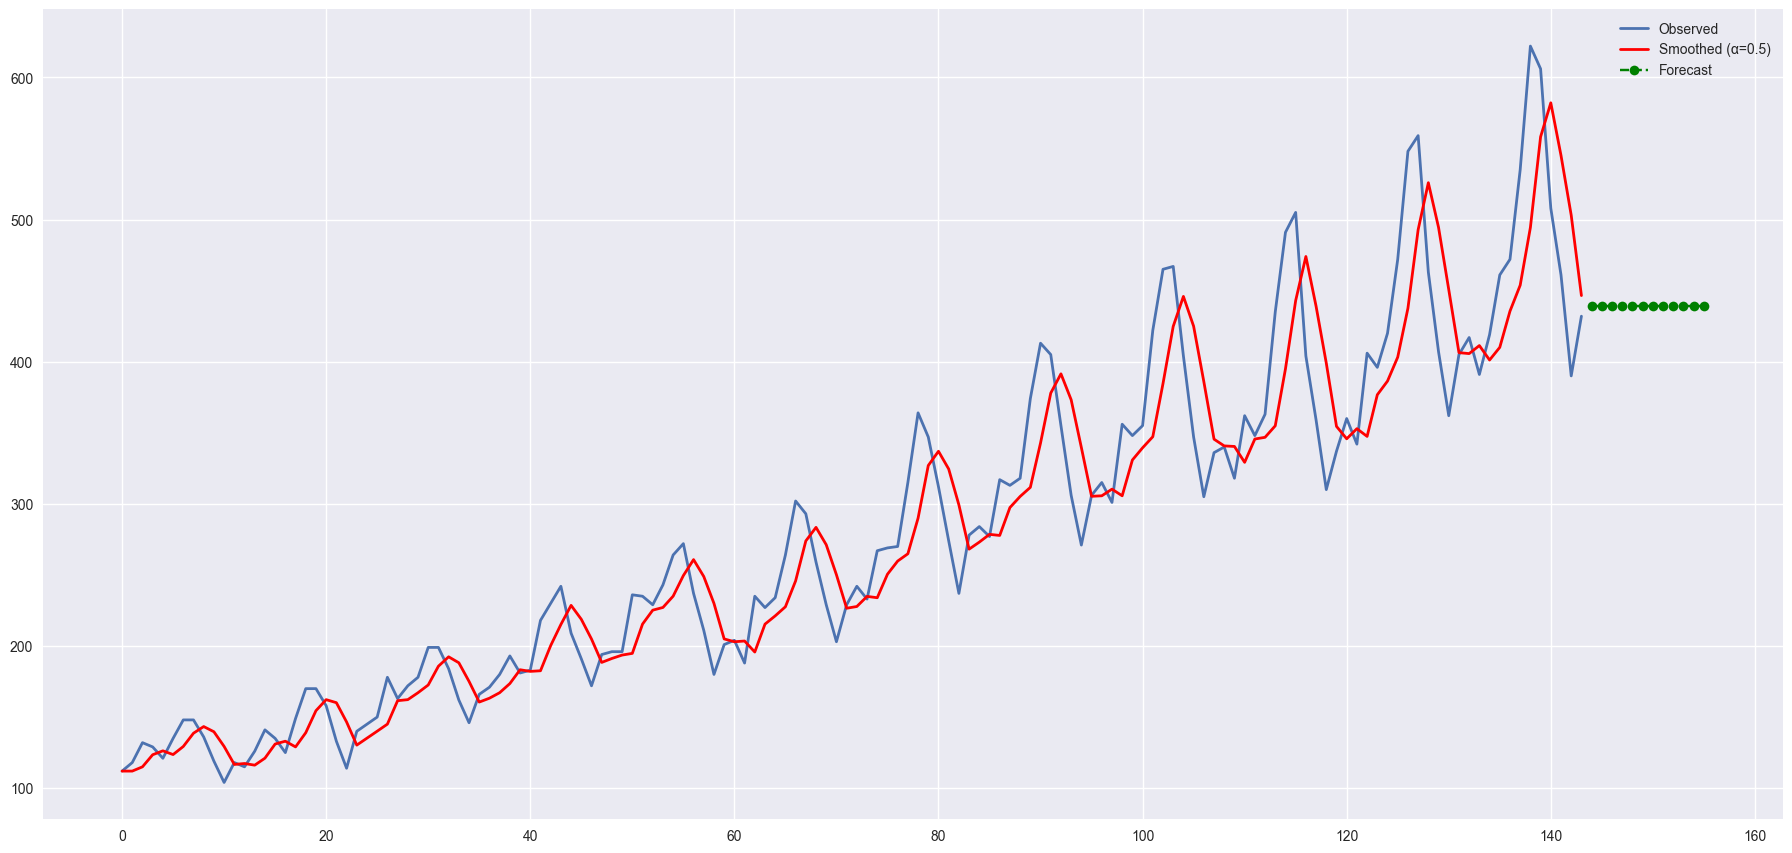

In [27]:
ALPHA = 0.5
HORIZON = 12

passengers_df = pd.read_csv( CFG.data_folder + "passengers.csv", usecols=["passengers"])

plot_ses_smoothing( passengers_df, alpha=ALPHA, horizon=HORIZON, value_col="passengers")

This code applies Simple Exponential Smoothing (SES) to a time series dataset of passenger numbers and visualizes the results using the `plot_ses_smoothing` function we've discussed. Let’s break it down:

*   `ALPHA = 0.5`: This line defines a constant variable named `ALPHA` and sets its value to 0.5.  This represents the smoothing level that will be used in the SES model. A value of 0.5 means that each new observation is given half the weight of the previous forecast, and the previous forecast receives the other half.

*   `HORIZON = 12`: This line defines a constant variable named `HORIZON` and sets its value to 12.  This represents the number of time periods into the future for which we want to generate forecasts. In this context, it likely means forecasting passenger numbers for the next 12 months (or whatever the time unit is in your dataset).

*   `passengers_df = pd.read_csv( CFG.data_folder + "passengers.csv", usecols=["passengers"])`: This line reads data from a CSV file named "passengers.csv" located in the directory specified by `CFG.data_folder`.
    *   `pd.read_csv(...)`:  This is the Pandas function for reading data from a comma-separated value (CSV) file.
    *   `usecols=["passengers"]`: This argument tells `read_csv` to only read the column named "passengers" from the CSV file, creating a DataFrame with just that single column.

*   `plot_ses_smoothing( passengers_df, alpha=ALPHA, horizon=HORIZON, value_col="passengers")`:  This line calls the `plot_ses_smoothing` function to perform SES and generate a visualization.
    *   `passengers_df`: This passes the DataFrame containing the passenger data as the first argument (`series_df`).
    *   `alpha=ALPHA`: This sets the smoothing level for the SES model to the value stored in the `ALPHA` variable (0.5).
    *   `horizon=HORIZON`:  This sets the forecast horizon to the value stored in the `HORIZON` variable (12).
    *   `value_col="passengers"`: This specifies that the column named "passengers" in the DataFrame contains the time series values.


## Double Exponential Smoothing


In [28]:
# wrapper function - similar to plot_ses_smoothing

def plot_holt_smoothing( series_df, alpha, beta, horizon,  value_col):
    holt_model = Holt(series_df[value_col])
    holt_fit = holt_model.fit(
        smoothing_level=alpha, smoothing_slope=beta, optimized=False,
    )

    forecast = holt_fit.forecast(horizon)

    plt.figure()

    series_df[value_col].plot( label="Observed", linewidth=2    )

    holt_fit.fittedvalues.plot( label=f"Smoothed (α={alpha}, β={beta})",linewidth=2, color = "red"     )

    forecast.plot( label="Forecast",  marker="o", linestyle="--", color="green" )


    plt.title("Holt’s Linear Trend Method")
    plt.legend()
    plt.show()


This code defines a function `plot_holt_smoothing` that visualizes the results of applying Holt's linear trend method to a time series dataset. It’s very similar in structure to the `plot_ses_smoothing` function we previously discussed, but it implements a more sophisticated smoothing technique that accounts for trends in the data.


*   `def plot_holt_smoothing( series_df, alpha, beta, horizon,  value_col):`: This defines a function named `plot_holt_smoothing` that takes five arguments:
    *   `series_df`: A Pandas DataFrame containing your time series data. It's expected to have a column with the time series values.
    *   `alpha`: The smoothing level for the level component of Holt’s method, controlling how much weight is given to recent observations when updating the current level.
    *   `beta`: The smoothing level for the trend component of Holt’s method, controlling how much weight is given to recent changes in the series when updating the trend.
    *   `horizon`:  The number of time periods into the future you want to forecast.
    *   `value_col`: Specifies the name of the column in `series_df` that contains the time series values.

*   `holt_model = Holt(series_df[value_col])`: This creates an instance of the `Holt` class from the `statsmodels` library, initializing it with the time series data from the specified column in the DataFrame.  The `Holt` method is designed for time series that exhibit a trend (increasing or decreasing pattern).

*   `holt_fit = holt_model.fit( smoothing_level=alpha, smoothing_slope=beta, optimized=False,)`: This fits (trains) the Holt’s model to the data using the provided smoothing levels for both the level (`alpha`) and trend (`beta`) components. `optimized=False` prevents automatic optimization of these parameters; we're explicitly setting them.

*   `forecast = holt_fit.forecast(horizon)`:  This generates a forecast for the specified `horizon` (number of periods into the future) using the fitted Holt’s model.

*   `plt.figure()`: This creates a new Matplotlib figure, which will contain the plot.

*   `series_df[value_col].plot( label="Observed", linewidth=2 )`:  This plots the original time series data as a line with a width of 2. The `label="Observed"` assigns a label to this line for use in the legend.

*   `holt_fit.fittedvalues.plot( label=f"Smoothed (α={alpha}, β={beta})",linewidth=2, color = "red" )`: This plots the smoothed values generated by Holt’s model (the *in-sample fitted values*) as a line with a line width of 2 and a **red** color. The `label` dynamically includes the values of both `alpha` and `beta`, making it clear which smoothing levels were used.

*   `forecast.plot( label="Forecast",  marker="o", linestyle="--", color="green" )`: This plots the forecasted values as a dashed line (`linestyle="--"`) with circular markers (`marker="o"`), and a **green** color. The `label="Forecast"` assigns a label for the legend.

*   `plt.title("Holt’s Linear Trend Method")`:  This sets the title of the plot to "Holt’s Linear Trend Method", indicating which forecasting method is being visualized.

*   `plt.legend()`:  This displays the legend on the plot, showing the labels assigned to each line (Observed, Smoothed, Forecast). The different colors will be represented in the legend as well.

*   `plt.show()`: This displays the generated plot.

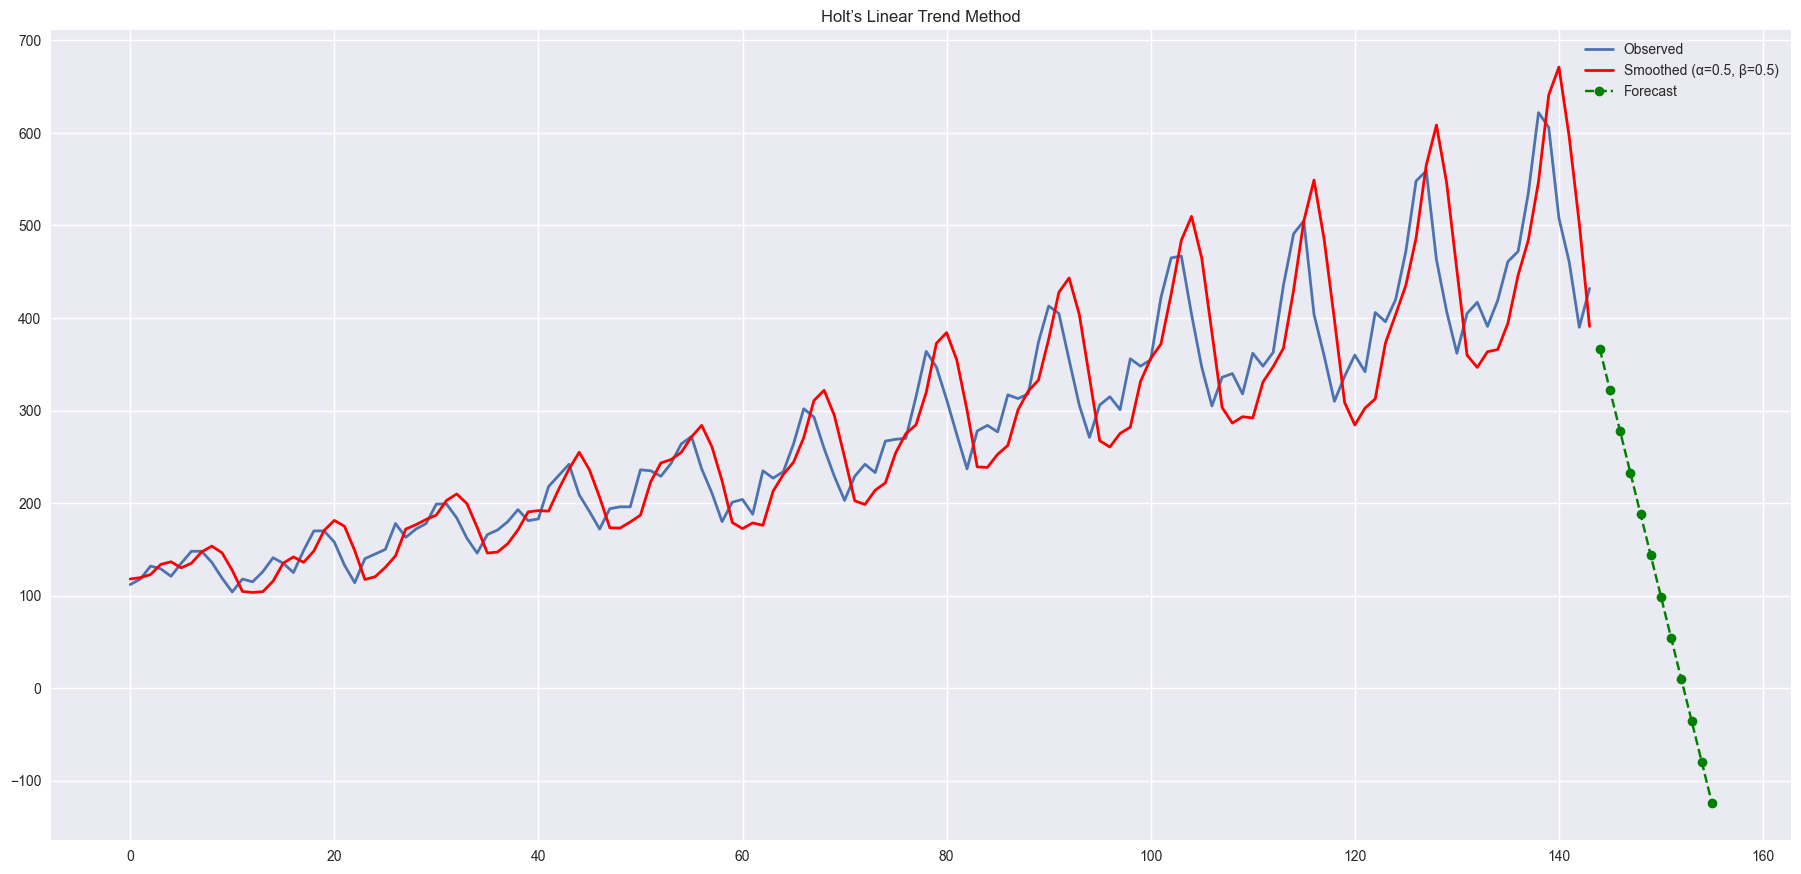

In [29]:
LEVEL_ALPHA = 0.5
TREND_BETA = 0.5
HORIZON = 12

plot_holt_smoothing(
    passengers_df, alpha=LEVEL_ALPHA,  beta=TREND_BETA, horizon=HORIZON,  value_col="passengers")

This code snippet applies Holt's linear trend method to the passenger data and visualizes the results using the `plot_holt_smoothing` function. 

*   `LEVEL_ALPHA = 0.5`: This line defines a constant variable named `LEVEL_ALPHA` and sets its value to 0.5.  This represents the smoothing level for the *level* component of Holt's method. It controls how much weight is given to recent observations when updating the current level of the series.

*   `TREND_BETA = 0.5`: This line defines a constant variable named `TREND_BETA` and sets its value to 0.5.  This represents the smoothing level for the *trend* component of Holt's method. It controls how much weight is given to recent changes in the series when updating the trend.

*   `HORIZON = 12`: This line defines a constant variable named `HORIZON` and sets its value to 12.  This represents the number of time periods into the future for which we want to generate forecasts. In this context, it likely means forecasting passenger numbers for the next 12 months (or whatever the time unit is in your dataset).

*   `plot_holt_smoothing( passengers_df, alpha=LEVEL_ALPHA,  beta=TREND_BETA, horizon=HORIZON,  value_col="passengers")`: This line calls the `plot_holt_smoothing` function to perform Holt's smoothing and generate a visualization.
    *   `passengers_df`: This passes the DataFrame containing the passenger data as the first argument (`series_df`).
    *   `alpha=LEVEL_ALPHA`: This sets the smoothing level for the level component of Holt’s method to the value stored in the `LEVEL_ALPHA` variable (0.5).
    *   `beta=TREND_BETA`:  This sets the smoothing level for the trend component of Holt’s method to the value stored in the `TREND_BETA` variable (0.5).
    *   `horizon=HORIZON`: This sets the forecast horizon to the value stored in the `HORIZON` variable (12).
    *   `value_col="passengers"`: This specifies that the column named "passengers" in the DataFrame contains the time series values.


## Triple exponential smoothing

In [30]:
def plot_holt_winters_additive( series_df, alpha, seasonal_period, horizon, value_col, y_lim=None):
    hw_model = ExponentialSmoothing(
        series_df[value_col],
        trend="add", seasonal="mul", seasonal_periods=seasonal_period,
    )

    hw_fit = hw_model.fit( smoothing_level=alpha, optimized= True,)

    forecast = hw_fit.forecast(horizon)

    plt.figure()

    series_df[value_col].plot( label="Observed", linewidth=2    )

    hw_fit.fittedvalues.plot( label="Smoothed", linewidth=2,color = "red")

    forecast.plot(label="Forecast", marker="o", linestyle="--")

    plt.title("Holt-Winters Additive Smoothing")
    plt.legend()

    if y_lim is not None:
        plt.ylim(y_lim)

    plt.show()


This code defines a function `plot_holt_winters_additive` that visualizes the results of applying Holt-Winters' additive smoothing method to a time series dataset. This method is particularly useful for data exhibiting both trend and seasonality.

*   `def plot_holt_winters_additive( series_df, alpha, seasonal_period, horizon, value_col, y_lim=None):`:  This defines a function named `plot_holt_winters_additive` that takes six arguments:
    *   `series_df`: A Pandas DataFrame containing your time series data. It's expected to have a column with the time series values.
    *   `alpha`: The smoothing level for the level component of Holt-Winters’ method, controlling how much weight is given to recent observations when updating the current level.
    *   `seasonal_period`:  The length of the seasonal cycle in your data (e.g., 12 for monthly data with yearly seasonality).
    *   `horizon`: The number of time periods into the future you want to forecast.
    *   `value_col`: Specifies the name of the column in `series_df` that contains the time series values.
    *   `y_lim=None`: An optional argument allowing you to set the y-axis limits for the plot. If not provided (i.e., remains `None`), the plot will automatically determine appropriate limits.

*   `hw_model = ExponentialSmoothing( series_df[value_col], trend="add", seasonal="mul", seasonal_periods=seasonal_period,)`: This creates an instance of the `ExponentialSmoothing` class from the `statsmodels` library, initializing it with the time series data and specifying the model parameters.
    *   `series_df[value_col]`:  Provides the time series data to the model.
    *   `trend="add"`: Specifies that an additive trend component should be included in the model. This means the trend is added to the level of the series.
    *   `seasonal="mul"`: Specifies a multiplicative seasonal component. This means the seasonality is multiplied by the level of the series.  (Additive seasonality could also be used, but multiplicative is often preferred when the magnitude of the seasonal fluctuations changes with the level of the series).
    *   `seasonal_periods=seasonal_period`: Sets the length of the seasonal cycle.

*   `hw_fit = hw_model.fit( smoothing_level=alpha, optimized= True,)`: This fits (trains) the Holt-Winters model to the data using the provided smoothing level for the level component (`alpha`).
    *   `optimized=True`:  This is important! It tells `ExponentialSmoothing` to automatically find the optimal values for all smoothing parameters (level, trend, and seasonality) using optimization techniques. This often leads to better forecasting accuracy than manually setting these parameters.

*   `forecast = hw_fit.forecast(horizon)`: This generates a forecast for the specified `horizon` (number of periods into the future) using the fitted Holt-Winters model.

*   `plt.figure()`: This creates a new Matplotlib figure, which will contain the plot.

*   `series_df[value_col].plot( label="Observed", linewidth=2 )`:  This plots the original time series data as a line with a default black color and a line width of 2. The `label="Observed"` assigns a label to this line for use in the legend.

*   `hw_fit.fittedvalues.plot( label="Smoothed", linewidth=2,color = "red")`: This plots the smoothed values generated by Holt-Winters’ model (the *in-sample fitted values*) as a line with a line width of 2 and a **red** color. The `label` is set to “Smoothed”.

*   `forecast.plot(label="Forecast", marker="o", linestyle="--")`: This plots the forecasted values as a dashed line (`linestyle="--"`) with circular markers (`marker="o"`). The `label="Forecast"` assigns a label for the legend.

*   `plt.title("Holt-Winters Additive Smoothing")`:  This sets the title of the plot to "Holt-Winters Additive Smoothing", indicating which forecasting method is being visualized.

*   `plt.legend()`: This displays the legend on the plot, showing the labels assigned to each line (Observed, Smoothed, Forecast).

*   `if y_lim is not None: plt.ylim(y_lim)`:  This conditionally sets the y-axis limits of the plot if a `y_lim` value was provided as an argument to the function. This can be useful for comparing plots with different scales.

*   `plt.show()`: This displays the generated plot.

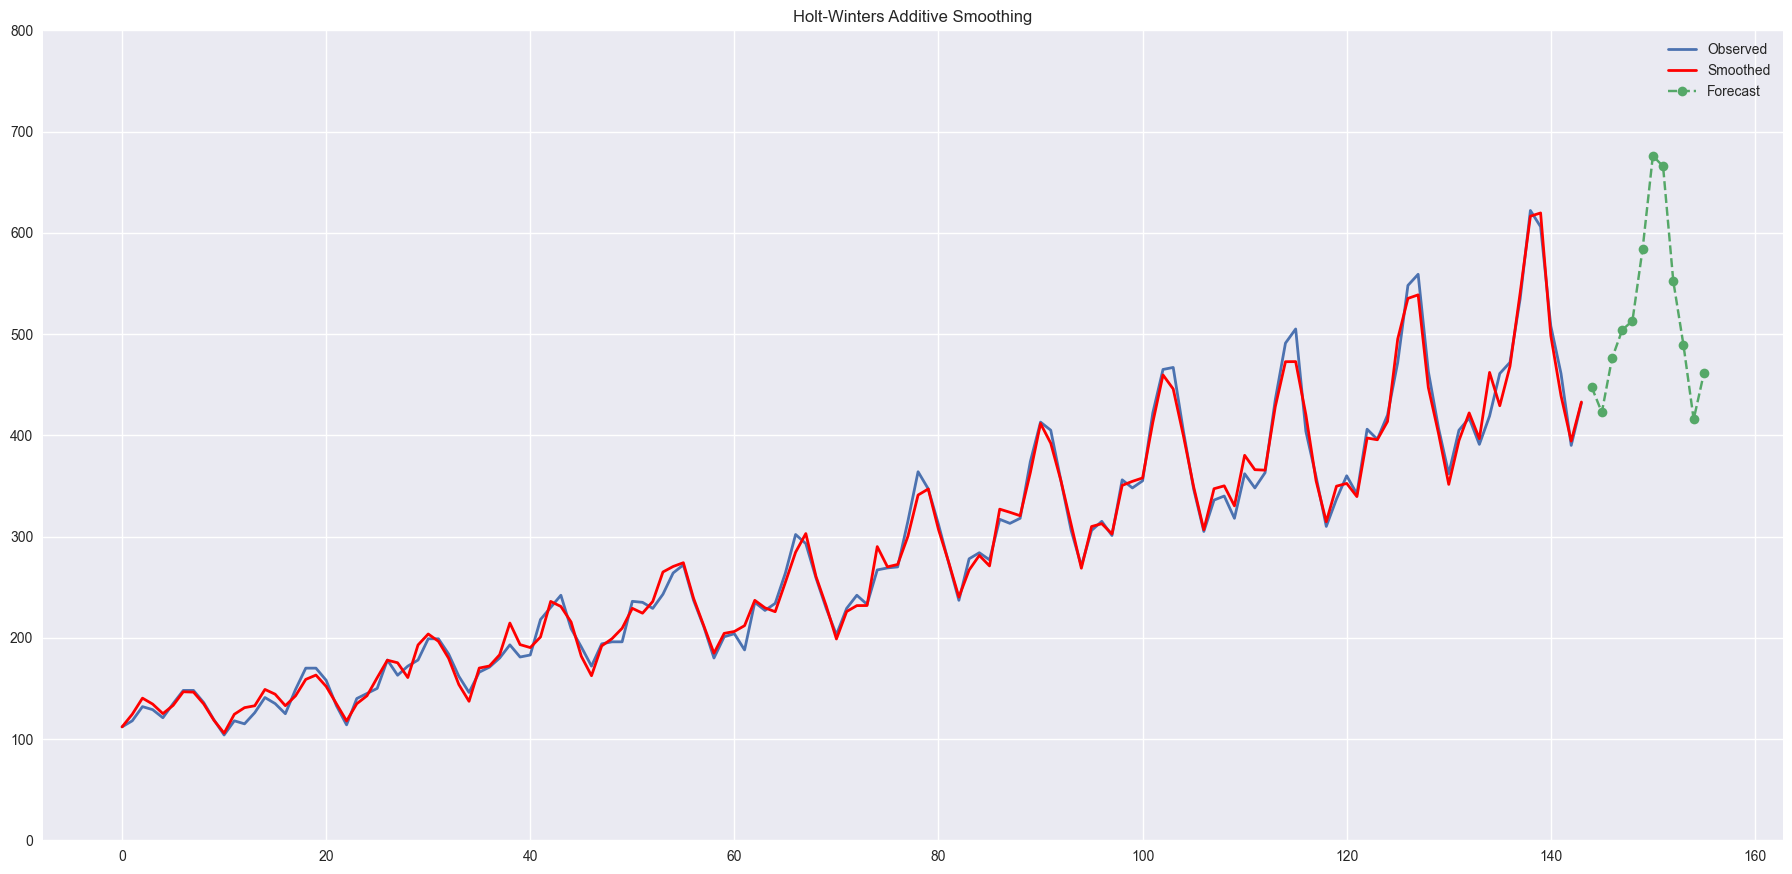

In [31]:
LEVEL_ALPHA = 0.5
SEASONAL_PERIOD = 12
HORIZON = 12
Y_LIM = (0, 800)

plot_holt_winters_additive(
    passengers_df,
    alpha=LEVEL_ALPHA,
    seasonal_period=SEASONAL_PERIOD,
    horizon=HORIZON,
    value_col="passengers",
    y_lim=Y_LIM,
)


This code snippet applies Holt-Winters' exponential smoothing to the "passengers" dataset, which is suitable for time series data with both trend and seasonality. It forecasts 12 periods into the future and visualizes the smoothed data (fitted values) and the forecast. 

**1. Data Loading & Initial Plotting:**

*   `alpha = 0.5`: Sets a variable `alpha`, which is used as the smoothing level in this case, but note that Holt-Winters automatically optimizes all smoothing parameters if not explicitly set.
*   `df.plot.line()`: Creates a line plot of the original time series data, showing the raw passenger numbers over time.

**2. Holt-Winters Exponential Smoothing & Fitting:**

*   `fit1 = ExponentialSmoothing(df, seasonal_periods=12, trend='add', seasonal='add')`:
    *   `ExponentialSmoothing(df, ...)`: Creates an instance of the `ExponentialSmoothing` class from `statsmodels`, initializing it with the time series data (`df`). This is the core Holt-Winters implementation.
        *   `seasonal_periods=12`: Specifies that the seasonality has a period of 12 (e.g., monthly data with yearly seasonality).  This tells the model to look for repeating patterns every 12 periods.
        *   `trend='add'`: Indicates that the trend component is additive. This means the trend is added to the seasonal and level components. Use `'mul'` for a multiplicative trend (where the trend multiplies the other components).
        *   `seasonal='add'`:  Indicates that the seasonal component is additive. This means the seasonality is added to the level and trend components. Use `'mul'` for a multiplicative seasonal component.

*   `fit1 = fit1.fit(smoothing_level=0.5)`: Fits the Holt-Winters model to the data.
    * `smoothing_level=0.5`: Sets the initial smoothing level (alpha) to 0.5.  However, because no other smoothing parameters are explicitly set, statsmodels will *optimize* all three smoothing parameters (alpha, beta for trend, and gamma for seasonality) to find the best fit to the data.

**3. Plotting Fitted Values:**

*   `fit1.fittedvalues.plot(color='red')`: Plots the fitted values (the smoothed time series) generated by the Holt-Winters model as a red line. These represent the estimated values of the time series based on the trend and seasonal components.

**4. Plotting Forecasts:**

*   `fit1.forecast(12).rename("Holt-Winters smoothing").plot(color='red', legend=True)`:
    *   `fit1.forecast(12)`: Uses the fitted model (`fit1`) to generate forecasts for the next 12 time steps (periods).
    *   `.rename(...)`: Renames the forecast series in the DataFrame to "Holt-Winters smoothing", making it easier to identify on the plot.
    *   `.plot(color='red', legend=True)`: Plots the forecasted values as a red line and adds them to the legend.

**5. Setting Y-axis Limits & Displaying Plot:**

*   `plt.ylim(0, 800)`: Sets the limits of the y-axis (vertical axis) of the plot from 0 to 800. This ensures that the entire time series and forecast are visible within the plot's bounds.
*   `plt.show()`: Displays the plot, showing the original time series, the fitted values, and the forecasts generated by Holt-Winters smoothing.

# Application: anomaly detection 

<Axes: >

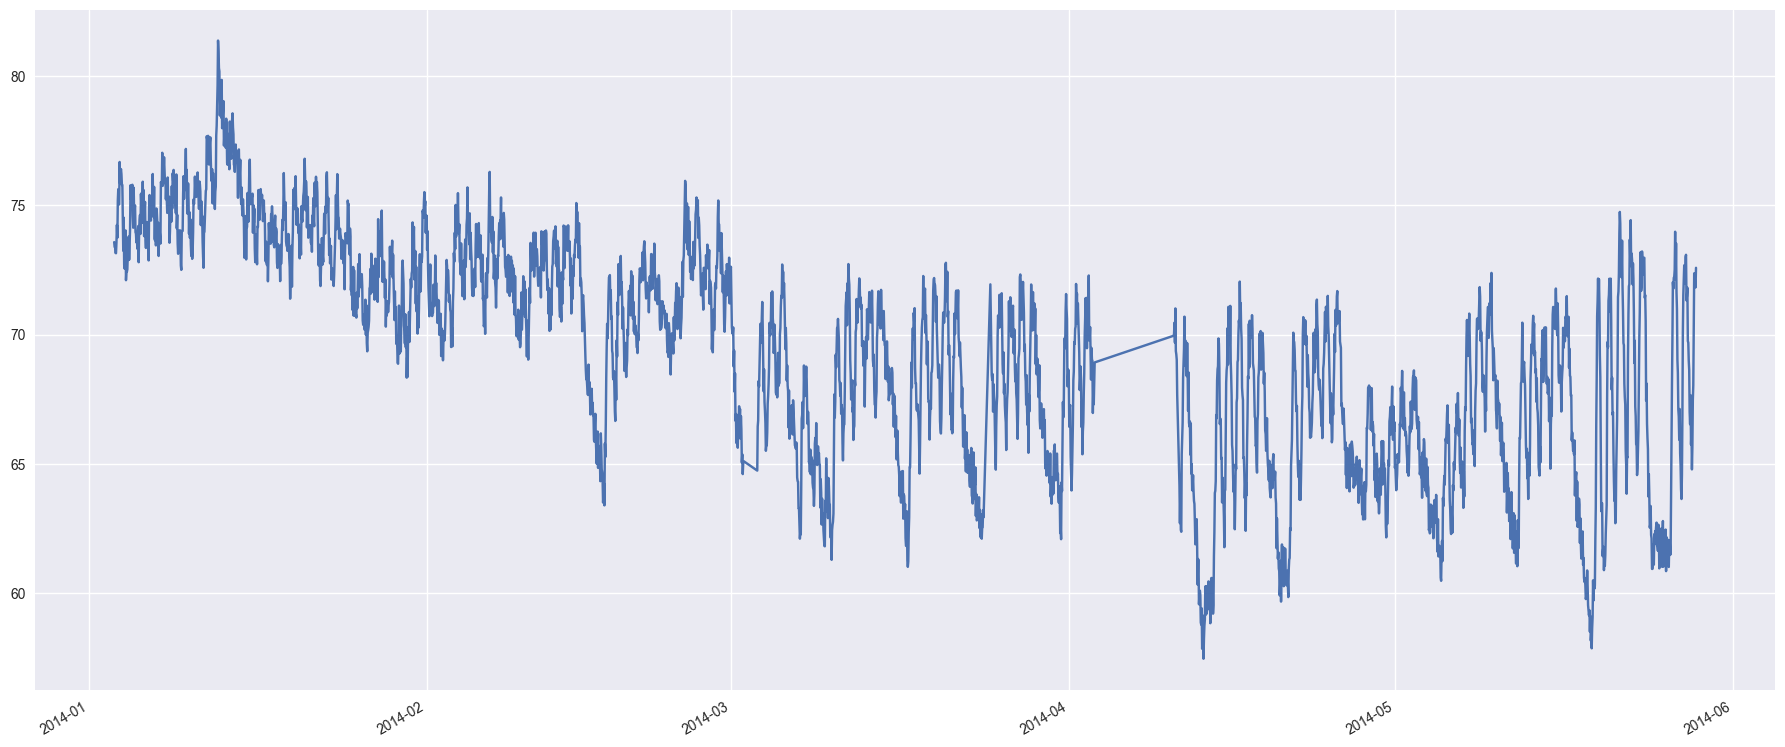

In [32]:
ambient_df = pd.read_csv(CFG.data_folder + 'ambient_temperature_system_failure.csv')
ambient_df['timestamp'] = pd.to_datetime(ambient_df['timestamp'])
ambient_df.set_index('timestamp', inplace=True)

ambient_df['value'].plot(xlabel = "")

This code snippet loads time series data from a CSV file, prepares it for analysis by converting the timestamp column to datetime objects and setting it as the index, and then plots the time series.  

*   `series = pd.read_csv(CFG.data_folder + 'ambient_temperature_system_failure.csv')`: This line reads data from a CSV file named "ambient\_temperature\_system\_failure.csv" located in the directory specified by `CFG.data_folder`.  The `pd.read_csv()` function is used to import the data into a Pandas DataFrame called `series`.

*   `series['timestamp'] = pd.to_datetime(series['timestamp'])`: This line converts the 'timestamp' column in the DataFrame to datetime objects.
    *   `series['timestamp']`: Selects the 'timestamp' column from the DataFrame.
    *   `pd.to_datetime(...)`:  This Pandas function parses strings representing dates and times into Python datetime objects, which are essential for time series analysis.

*   `series.set_index('timestamp', inplace=True)`: This line sets the 'timestamp' column as the index of the DataFrame.
    *   `series.set_index('timestamp')`:  This method changes the DataFrame so that the values in the 'timestamp' column are used as the row labels (the index).
    *   `inplace=True`: This argument modifies the DataFrame directly, rather than creating a new copy.

*   `series['value'].plot(xlabel = "")`: This line plots the time series data.
    *   `series['value']`: Selects the 'value' column from the DataFrame (presumably containing the temperature readings).
    *   `.plot()`:  This Pandas method creates a line plot of the selected data.
    *   `xlabel = ""`: This sets the label for the x-axis to an empty string, effectively removing it from the plot. Since the x-axis represents time and is already indicated by the datetime index, this can make the plot cleaner.

In [33]:
def compute_rolling_zscore(df, value_col, window):
    rolling_mean = df[value_col].rolling(window).mean()
    rolling_std = df[value_col].rolling(window).std()

    zscore = (df[value_col] - rolling_mean) / rolling_std

    return pd.DataFrame(
        {
            "zscore": zscore.abs(),
        },
        index=df.index,
    )

This function `compute_rolling_zscore` calculates the rolling Z-score for a given time series column within a DataFrame. The rolling Z-score is a useful technique for identifying anomalies or outliers in time series data because it measures how many standard deviations away from the mean each data point is, considering only a recent window of observations.

*   `def compute_rolling_zscore(df, value_col, window):`: This defines a function named `compute_rolling_zscore` that takes three arguments:
    *   `df`: The Pandas DataFrame containing your time series data.
    *   `value_col`:  The name of the column in the DataFrame that contains the time series values you want to analyze.
    *   `window`: The size of the rolling window (i.e., the number of previous data points) used to calculate the mean and standard deviation.

*   `rolling_mean = df[value_col].rolling(window).mean()`: This calculates the rolling mean of the time series values.
    *   `df[value_col]`: Selects the specified column from the DataFrame.
    *   `.rolling(window)`: Creates a rolling window object that moves across the time series, considering `window` number of consecutive data points at each step.
    *   `.mean()`: Calculates the mean (average) value within each rolling window.

*   `rolling_std = df[value_col].rolling(window).std()`: This calculates the rolling standard deviation of the time series values, using the same rolling window as above.
    *   `.std()`:  Calculates the standard deviation within each rolling window. The standard deviation measures the spread or dispersion of the data around the mean.

*   `zscore = (df[value_col] - rolling_mean) / rolling_std`: This calculates the Z-score for each data point in the time series.
    *   `(df[value_col] - rolling_mean)`:  Calculates the difference between each original value and its corresponding rolling mean. This represents how much each value deviates from the average of its recent neighbors.
    *   `/ rolling_std`: Divides the deviation by the rolling standard deviation. This normalizes the deviation, expressing it in terms of standard deviations.

*   `return pd.DataFrame( { "zscore": zscore.abs(), }, index=df.index,)`:  This returns a new Pandas DataFrame containing the calculated Z-scores.
    *   `{"zscore": zscore.abs()}`: Creates a dictionary where the key is "zscore" and the value is the absolute value of the calculated Z-scores (`zscore.abs()`). Taking the absolute value ensures that both positive and negative deviations from the mean are considered as potential anomalies.
    *   `index=df.index`: Sets the index of the new DataFrame to be the same as the original DataFrame, ensuring that the Z-scores are aligned with their corresponding timestamps.

In [34]:
def plot_zscore_with_anomalies( zscore_df, value_col="zscore",  threshold=3.0):
    plt.figure()

    # Plot full z-score series
    zscore_df[value_col].plot(
        label="Z-score", linewidth=2)

    # Highlight anomalies
    anomalies = zscore_df[zscore_df[value_col] > threshold]

    plt.scatter(
        anomalies.index, anomalies[value_col],
        color="red", label=f"Anomalies (>{threshold})",
        zorder=3,)

    # plt.axhline( threshold,
    #     color="red",  linestyle="--", alpha=0.7,
    # )
    plt.legend()

    plt.show()


This function `plot_zscore_with_anomalies` visualizes a time series of Z-scores and highlights potential anomalies based on a specified threshold. It’s designed to help you identify unusual data points in your time series after calculating the rolling Z-score.

*   `def plot_zscore_with_anomalies( zscore_df, value_col="zscore",  threshold=3.0):`: This defines a function named `plot_zscore_with_anomalies` that takes three arguments:
    *   `zscore_df`: A Pandas DataFrame containing the Z-scores calculated using a function like `compute_rolling_zscore`.
    *   `value_col="zscore"`: The name of the column in the DataFrame that contains the Z-score values. It defaults to "zscore".
    *   `threshold=3.0`: A numerical value representing the threshold for identifying anomalies. Data points with a Z-score (absolute value) greater than this threshold are considered anomalies.

*   `plt.figure()`: This creates a new Matplotlib figure, which will contain the plot.

*   `zscore_df[value_col].plot( label="Z-score", linewidth=2)`: This plots the entire Z-score time series as a line graph.
    *   `zscore_df[value_col]`: Selects the column containing the Z-scores from the DataFrame.
    *   `.plot()`: Creates a line plot of the Z-score values.
    *   `label="Z-score"`: Assigns a label to the line for use in the legend.
    *   `linewidth=2`: Sets the width of the line to 2 points.

*   `anomalies = zscore_df[zscore_df[value_col] > threshold]`: This identifies the anomalies based on the specified threshold.
    *   `zscore_df[zscore_df[value_col] > threshold]`:  This uses boolean indexing to select rows from the `zscore_df` where the value in the `value_col` (Z-score) is greater than the `threshold`. These are considered anomalies.

*   `plt.scatter( anomalies.index, anomalies[value_col], color="red", label=f"Anomalies (>{threshold})", zorder=3,)`: This plots the identified anomalies as red scatter points on the graph.
    *   `anomalies.index`:  Provides the timestamps (or index values) of the anomalies for the x-axis.
    *   `anomalies[value_col]`: Provides the Z-score values of the anomalies for the y-axis.
    *   `color="red"`: Sets the color of the scatter points to red.
    *   `label=f"Anomalies (>{threshold})"`: Assigns a label to the scatter points, indicating that they represent anomalies with Z-scores greater than the threshold. The `f` before the string allows you to embed the value of the `threshold` variable directly into the label.
    *   `zorder=3`: Sets the z-order of the scatter points to 3, ensuring that they are drawn on top of the line plot (which has a default z-order of 0).

*   `plt.legend()`: This displays the legend on the plot, showing the labels for the Z-score line and the anomaly scatter points.

*   `plt.show()`: This displays the generated plot.


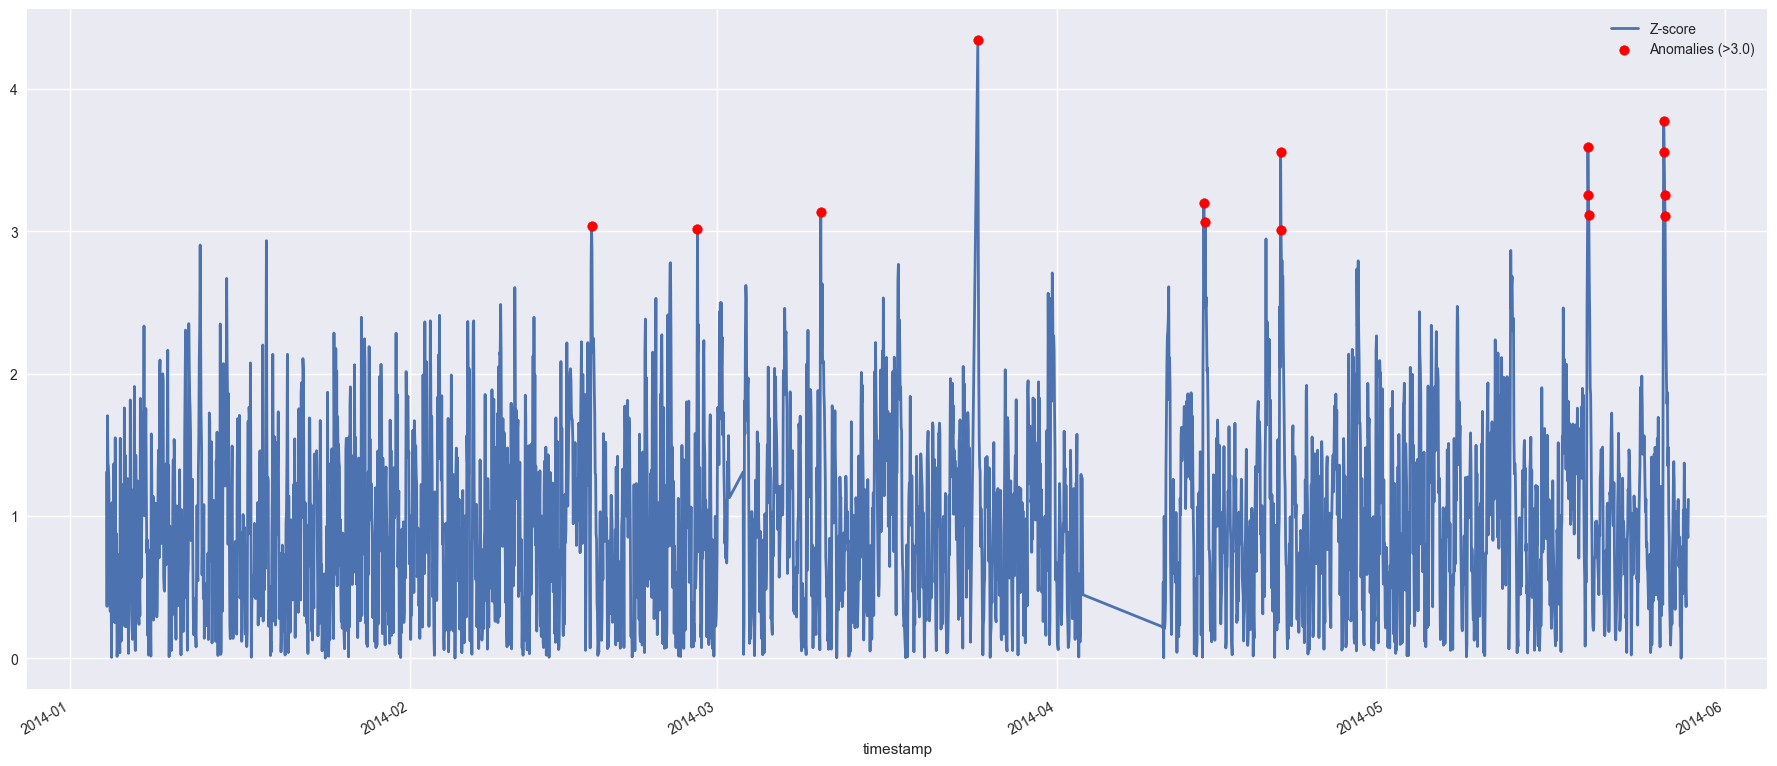

In [35]:
WINDOW_SIZE = 25
ZSCORE_THRESHOLD = 3.0

zscore_df = compute_rolling_zscore(
    ambient_df,
    value_col="value",
    window=WINDOW_SIZE,
)

plot_zscore_with_anomalies(
    zscore_df,
    threshold=ZSCORE_THRESHOLD)

This code snippet calculates the rolling Z-scores for a time series dataset and then visualizes those scores along with any identified anomalies. 
*   `WINDOW_SIZE = 25`: This line defines a constant variable named `WINDOW_SIZE` and sets its value to 25.  This represents the size of the rolling window used when calculating the Z-scores – meaning the mean and standard deviation are calculated using the previous 25 data points for each point in the time series.

*   `ZSCORE_THRESHOLD = 3.0`: This line defines a constant variable named `ZSCORE_THRESHOLD` and sets its value to 3.0.  This represents the threshold used to identify anomalies. Any Z-score (absolute value) greater than 3.0 will be considered an anomaly.

*   `zscore_df = compute_rolling_zscore( ambient_df, value_col="value", window=WINDOW_SIZE,)`: This line calls the `compute_rolling_zscore` function to calculate the rolling Z-scores for your time series data.
    *   `ambient_df`:  This is assumed to be a Pandas DataFrame containing your time series data (likely loaded earlier in your script). It’s expected to have a column named "value" containing the temperature readings.
    *   `value_col="value"`: This specifies that the column named "value" contains the time series values.
    *   `window=WINDOW_SIZE`:  This sets the size of the rolling window to the value stored in the `WINDOW_SIZE` variable (25). The function returns a DataFrame containing the calculated Z-scores, which is assigned to the variable `zscore_df`.

*   `plot_zscore_with_anomalies( zscore_df, threshold=ZSCORE_THRESHOLD)`: This line calls the `plot_zscore_with_anomalies` function to visualize the calculated Z-scores and highlight any anomalies.
    *   `zscore_df`:  This passes the DataFrame containing the Z-scores (calculated in the previous step) as input.
    *   `threshold=ZSCORE_THRESHOLD`: This sets the anomaly threshold to the value stored in the `ZSCORE_THRESHOLD` variable (3.0).


# Building a model

<Axes: >

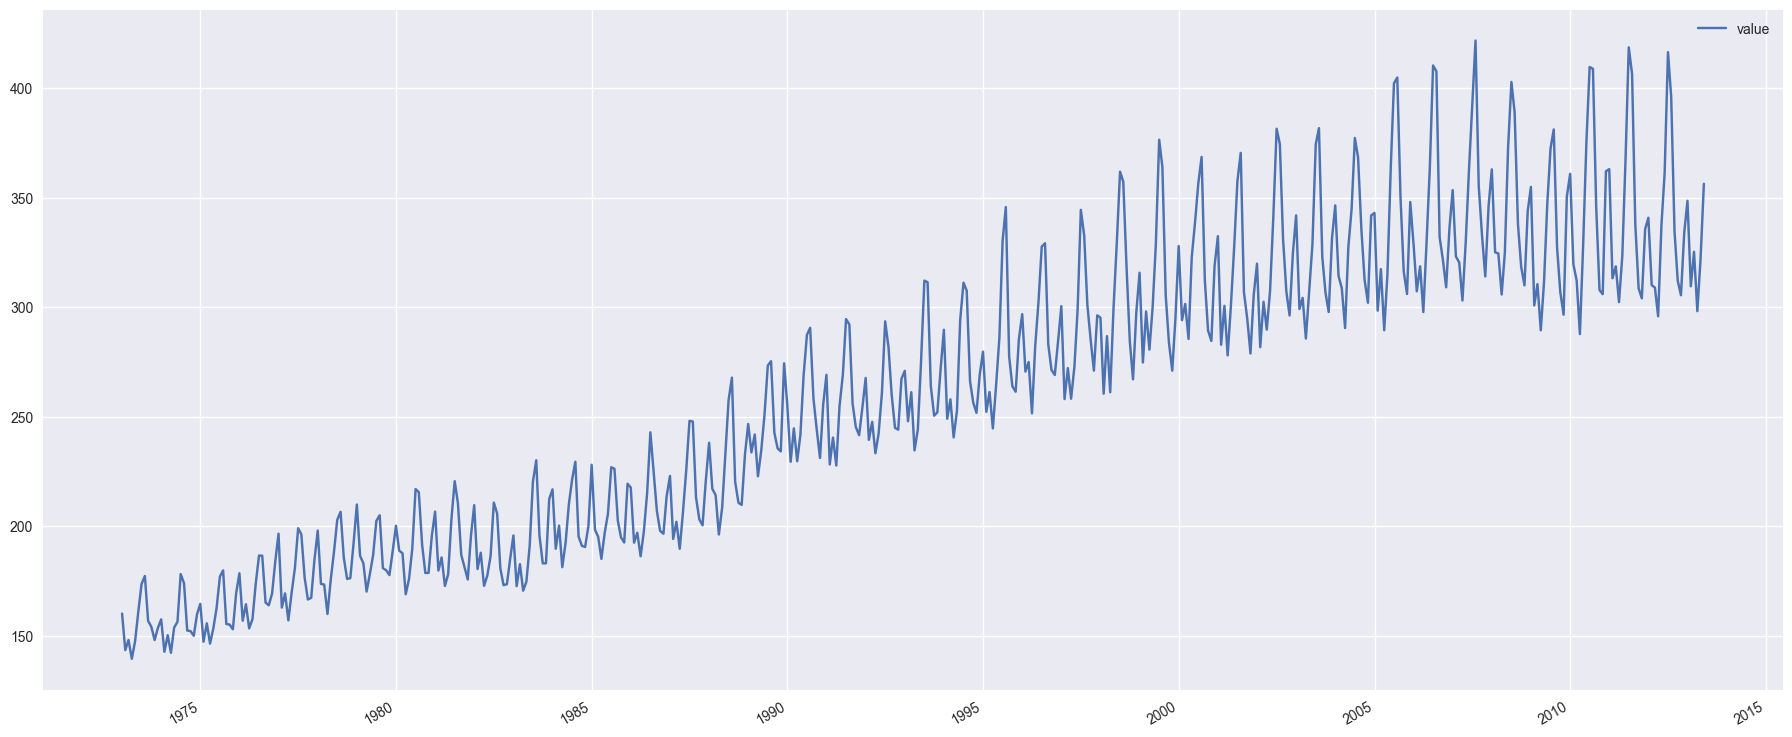

In [36]:
df = pd.read_csv(CFG.data_folder + 'us_energy.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace = True)
df.plot(xlabel="")

This load the CSV file containing US energy data, converts the 'date' column to datetime objects, sets the 'date' column as the DataFrame index, and then plots the time series data. 

**1. Loading the Data:**

*   `df = pd.read_csv(CFG.data_folder + 'us_energy.csv')`:
    *   `pd.read_csv(...)`: Reads a CSV file named "us_energy.csv" into a Pandas DataFrame called `df`.
    *   `CFG.data_folder`: Assumes that there's a configuration object (likely defined elsewhere in the code) named `CFG`, which has an attribute `data_folder` containing the path to the directory where the data file is located.

**2. Converting Date Column:**

*   `df['date'] = pd.to_datetime(df['date'])`:
    *   `df['date']`: Selects the column named 'date' from the DataFrame `df`. It assumes this column contains date information as strings or in a format Pandas can recognize.
    *   `pd.to_datetime(...)`: Converts the values in the 'date' column to datetime objects using Pandas' `to_datetime()` function. This is essential for time series analysis, allowing you to perform operations like indexing by date/time and calculating time differences. The resulting datetime objects are assigned back to the 'date' column of the DataFrame.

**3. Setting Date as Index:**

*   `df.set_index('date', inplace = True)`:
    *   `df.set_index('date')`: Sets the 'date' column as the index of the DataFrame `df`. This is a common practice in time series analysis, as it allows you to easily access data by date and perform time-based operations.
    *   `inplace = True`: Modifies the DataFrame `df` directly without creating a new copy.

**4. Plotting the Time Series:**

*   `df.plot(xlabel="")`: Creates a line plot of the time series data.  Since 'date' is now the index, Pandas automatically uses it as the x-axis.
    *   `xlabel=""`: Sets the label for the x-axis to an empty string, effectively removing the x-axis label from the plot. This might be done if the date information on the x-axis is already clear or if a custom label will be added later.


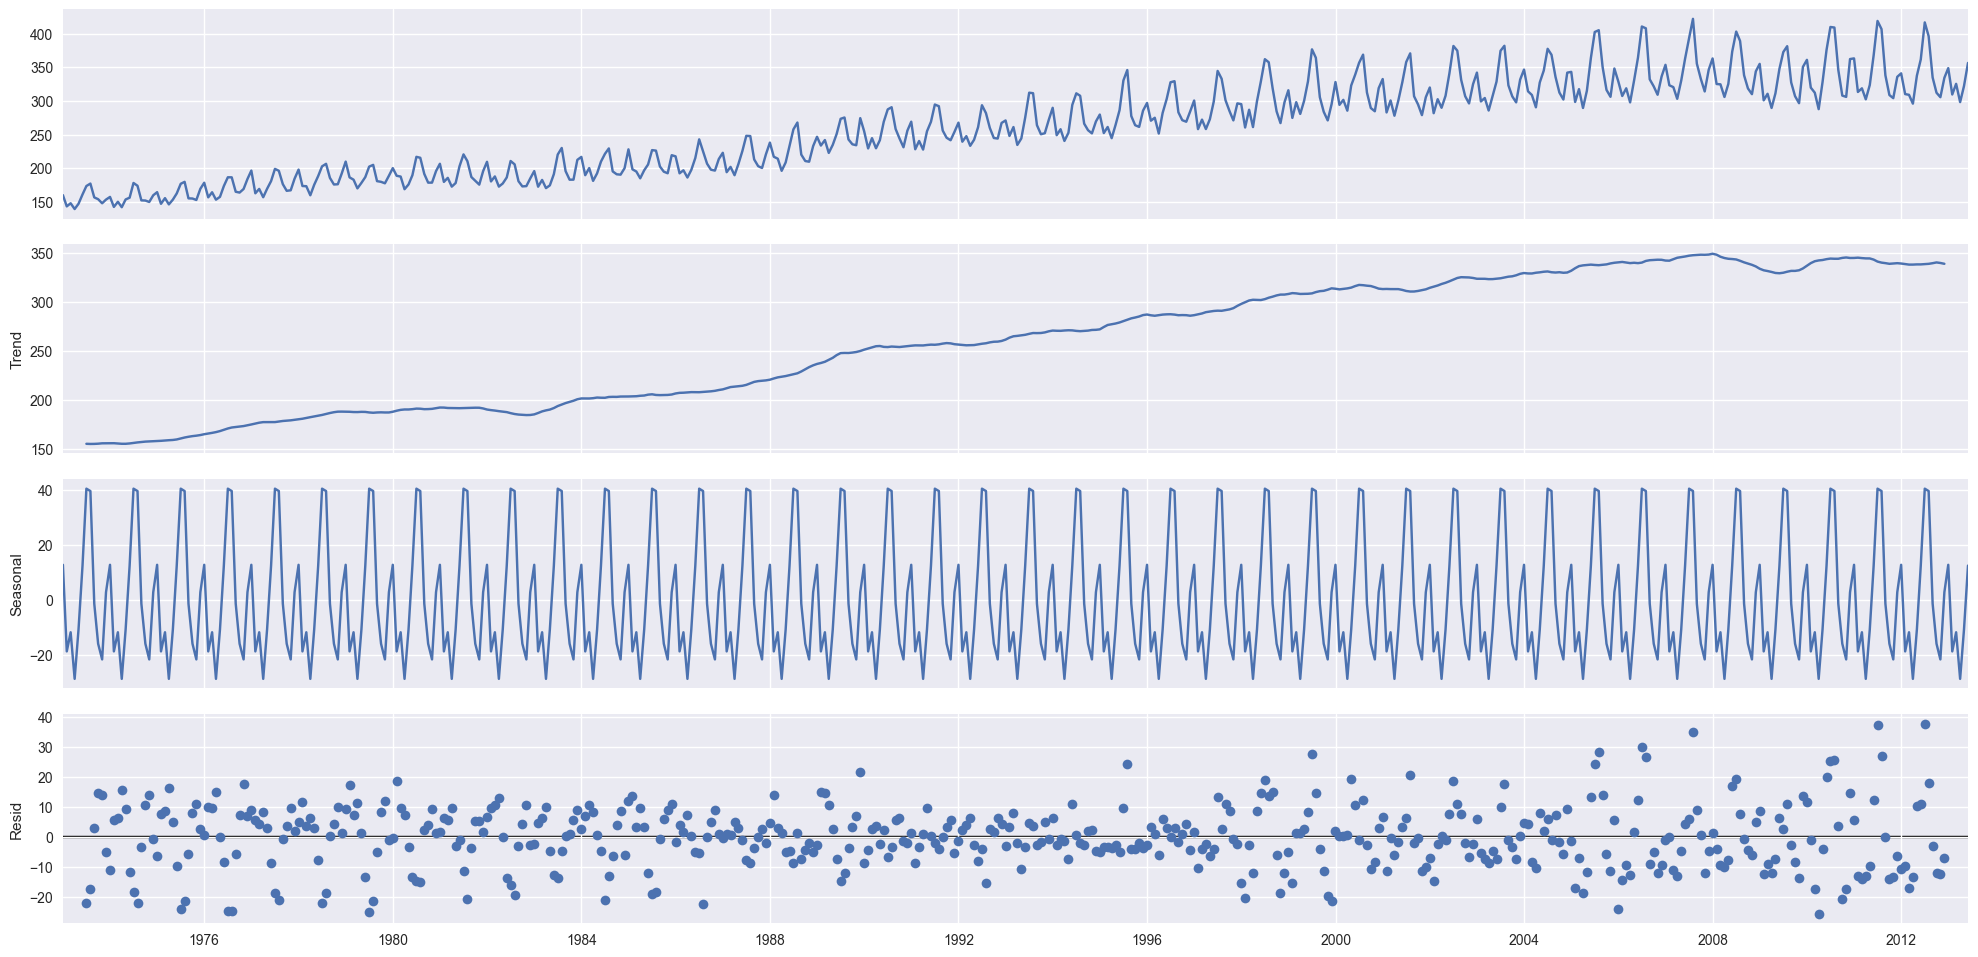

In [45]:
decomposition = seasonal_decompose(df["value"],period =12, model = 'additive')
figure = decomposition.plot()
for ax in figure.get_axes():
    ax.set_title("")
plt.show()

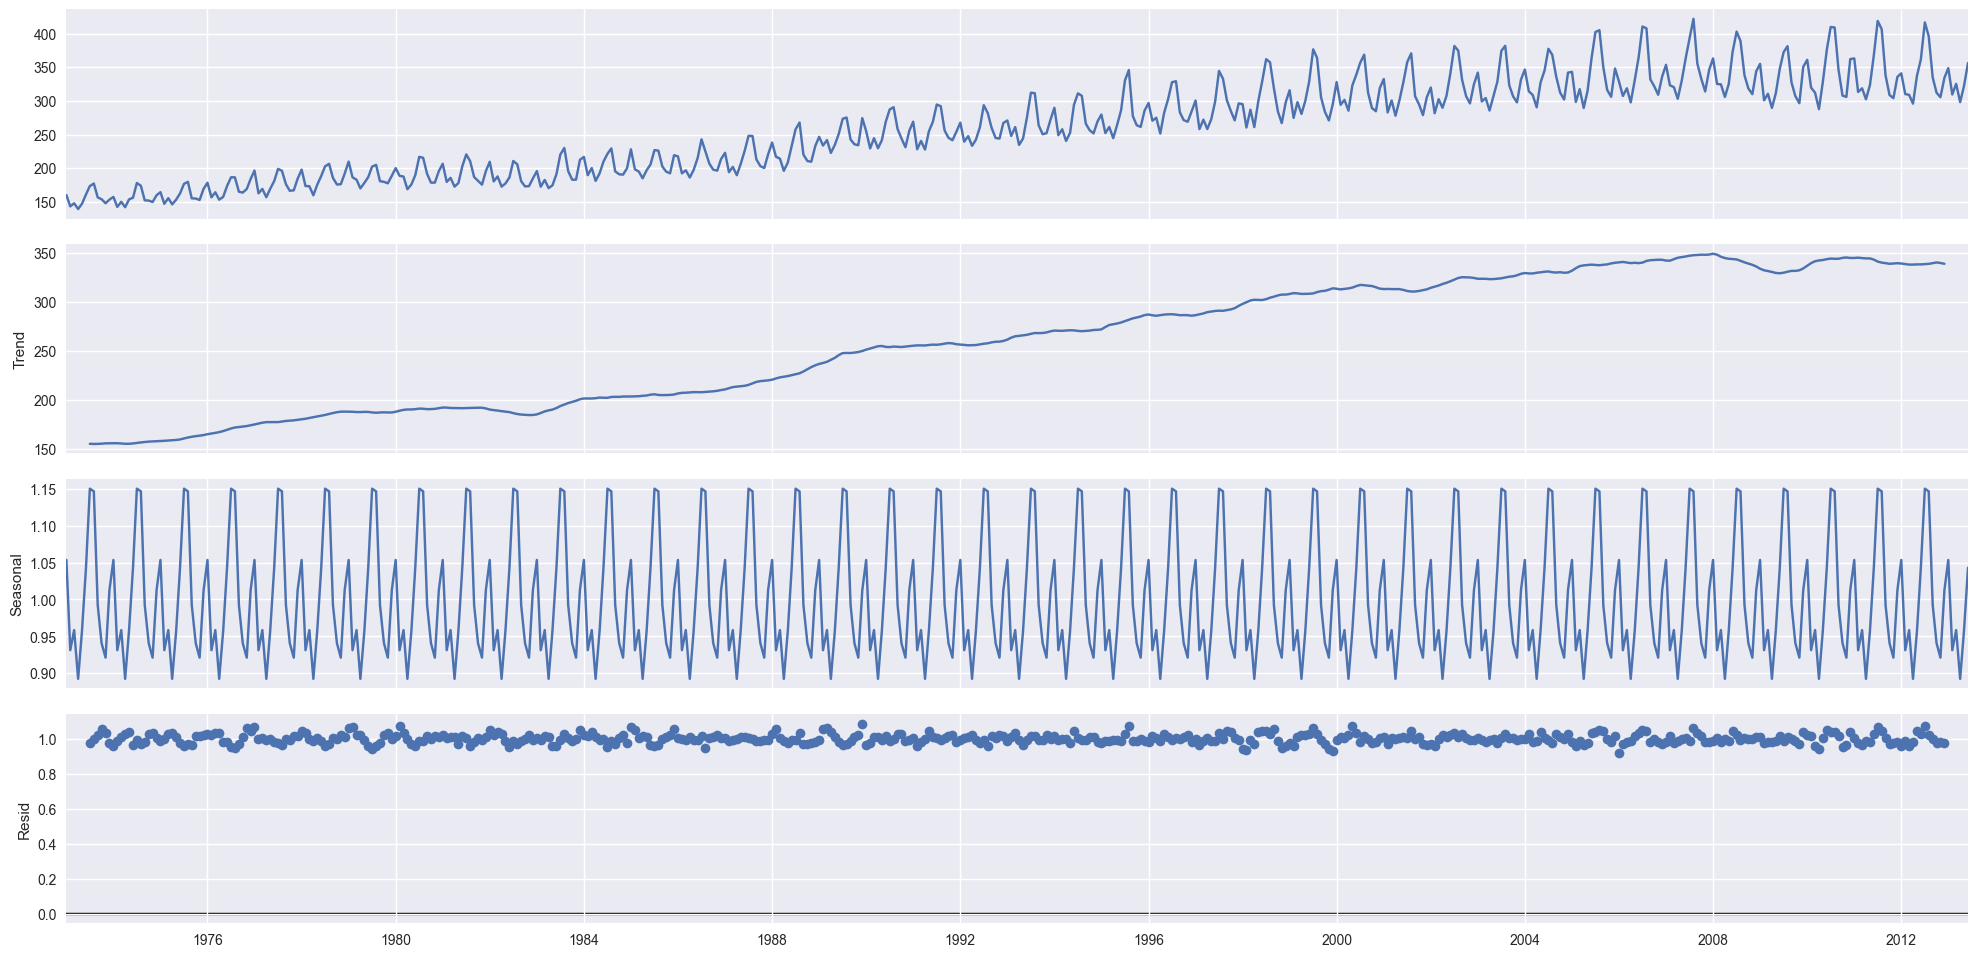

In [37]:
decomposition = seasonal_decompose(df["value"],period =12, model = 'multiplicative')
figure = decomposition.plot()
for ax in figure.get_axes():
    ax.set_title("")
plt.show()

This code performs a time series decomposition using the `seasonal_decompose` function from the `statsmodels` library and then visualizes the decomposed components (trend, seasonality, and residual).

*   `decomposition = seasonal_decompose(df["value"],period =12, model = 'multiplicative')`: This line performs the time series decomposition.
    *   `seasonal_decompose(...)`:  This function from `statsmodels.tsa.seasonal` decomposes a time series into its constituent components: trend, seasonality, and residual (random noise).
    *   `df["value"]`: Specifies the time series data to be decomposed. It assumes your DataFrame (`df`) has a column named "value" containing the time series values.
    *   `period = 12`:  This sets the length of the seasonal cycle. A value of 12 suggests monthly seasonality (like yearly patterns repeating every 12 months). This is crucial for accurately identifying and separating the seasonal component.
    *   `model = 'multiplicative'`: This specifies the type of decomposition model to use. In a multiplicative model, the time series is assumed to be composed of trend * seasonality * residual.  This is appropriate when the magnitude of the seasonal fluctuations changes proportionally with the level of the series (e.g., larger seasonal swings during periods of higher overall values). An alternative would be `model='additive'`, which assumes the components are added together (trend + seasonality + residual).

*   `figure = decomposition.plot()`: This line generates a plot showing the decomposed time series components.
    *   `decomposition.plot()`:  This method creates a Matplotlib figure containing four subplots: the original time series, the trend component, the seasonal component, and the residual component. The function returns the `figure` object.

*   `for ax in figure.get_axes():`: This loop iterates through each subplot (axis) within the generated figure.
    *   `figure.get_axes()`:  This method returns a list of all the axes objects (subplots) in the figure.
    *   `for ax in ...:`: The `for` loop allows you to access and modify each subplot individually.

*   `ax.set_title("")`: This line removes the default title from each subplot.  The original titles generated by `seasonal_decompose` can sometimes be redundant or unclear, so this step cleans up the plot.

*   `plt.show()`: This displays the generated plot, showing the decomposed time series components.


In [38]:
cutoff_date = '2005-12-31'
train_df, valid_df = train_valid_split(df, cutoff_date)

This code snippet splits your time series data into training and validation sets using the `train_valid_split` function we discussed earlier. 

*   `cutoff_date = '2005-12-31'`: This line defines a string variable named `cutoff_date` and assigns it the value "2005-12-31".  This date represents the point at which you want to split your data. All data on or before this date will be used for training, and all data after this date will be used for validation (testing).

*   `train_df, valid_df = train_valid_split(df, cutoff_date)`: This line calls the `train_valid_split` function to perform the split.
    *   `train_valid_split(df, cutoff_date)`:  This calls the function with two arguments:
        *   `df`: The Pandas DataFrame containing your time series data (presumably loaded and prepared earlier). It’s expected to have a datetime index.
        *   `cutoff_date`: The date string ("2005-12-31") that determines the split point.
    *   `train_df, valid_df = ...`:  The `train_valid_split` function returns two DataFrames: the training set (`train_df`) and the validation set (`valid_df`). This line unpacks those returned values into separate variables.

In [39]:
fit1 = ExponentialSmoothing(train_df['value'].values, seasonal_periods=12, trend='mul', seasonal='mul')
fit1 = fit1.fit()

This code snippet fits an Exponential Smoothing model to your training data:

*   `fit1 = ExponentialSmoothing(train_df['value'].values, seasonal_periods=12, trend='mul', seasonal='mul')`: This line creates an instance of the `ExponentialSmoothing` model and configures its parameters.
    *   `ExponentialSmoothing(...)`:  This initializes a new Exponential Smoothing object.
    *   `train_df['value'].values`: Provides the training data to the model. It extracts the 'value' column from the `train_df` DataFrame and converts it into a NumPy array using `.values`. This is often necessary for compatibility with `statsmodels`.
    *   `seasonal_periods=12`: Specifies that the time series has a seasonal pattern repeating every 12 periods (e.g., months).  This is crucial if your data exhibits seasonality.
    *   `trend='mul'`: Sets the trend component to 'multiplicative'. This means the trend is modeled as a multiplicative factor applied to the level of the series. A multiplicative trend is appropriate when the magnitude of the trend increases or decreases over time.
    *   `seasonal='mul'`: Sets the seasonal component to 'multiplicative'.  This means the seasonality is modeled as a multiplicative factor applied to the level of the series. This is often used when the amplitude of the seasonal fluctuations changes with the level of the series.

*   `fit1 = fit1.fit()`: This line fits (trains) the Exponential Smoothing model to the training data.
    *   `.fit()`:  This method estimates the optimal smoothing parameters (alpha, beta, gamma) that minimize the error between the model's predictions and the actual values in the training data. Because we didn’t specify those smoothing levels ourselves, `statsmodels` will optimize them for us.

In [40]:
fit1.params_formatted

,name,param,optimized
smoothing_level,alpha,0.281657,True
smoothing_trend,beta,0.000000,True
smoothing_seasonal,gamma,0.226347,True
initial_level,l.0,155.198901,True
initial_trend,b.0,1.001948,True
initial_seasons.0,s.0,1.044362,True
initial_seasons.1,s.1,0.919946,True
initial_seasons.2,s.2,0.944655,True
initial_seasons.3,s.3,0.877853,True
initial_seasons.4,s.4,0.927012,True


Retrieve the  optimized parameter values (smoothing levels) from the fitted Holt-Winters exponential smoothing model (`fit1`):

*   `fit1.params_formatted`: This accesses the `params_formatted` attribute of the fitted `ExponentialSmoothing` object (`fit1`).
    *   `params_formatted`:  This is a Pandas Series that contains the optimized values for the smoothing parameters (alpha, beta, and gamma) used in the Holt-Winters model. It also includes their names and standard errors. The formatting makes it easy to read and understand the results of the optimization process.

*   `level`: Represents alpha (α), the smoothing level for the level component of the time series.  It controls how much weight is given to recent observations when estimating the current level.
*   `trend`: Represents beta (β), the smoothing factor for the trend component. It controls how much weight is given to recent changes in the slope (trend) of the series.
*   `seasonal`: Represents gamma (γ), the smoothing factor for the seasonal component.  It controls how much weight is given to recent seasonal fluctuations.


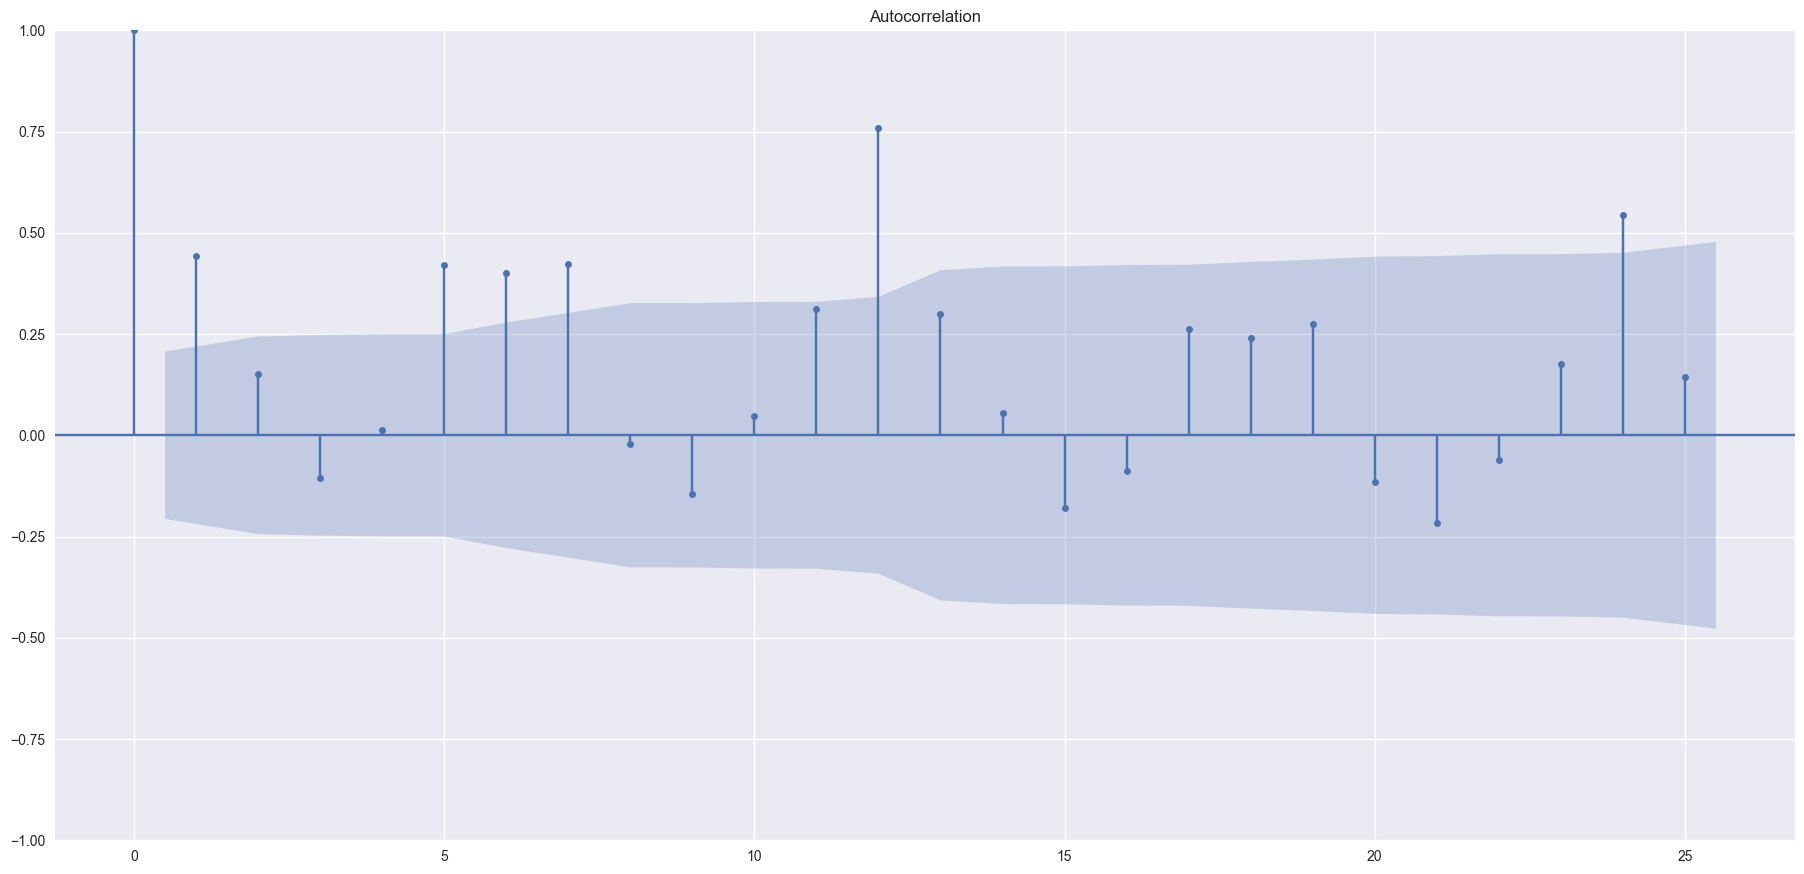

In [41]:
# fit the model
prediction = fit1.forecast(len(valid_df)).copy()
# compute the residuals
xresiduals = valid_df['value'] - prediction
plot_acf(xresiduals, lags = 25)
print()

This part analyzes the residuals (the differences between actual and predicted values) from your Holt-Winters model to assess its performance.  

**1. Forecasting on Validation Data:**

*   `prediction = fit1.forecast(len(xvalid)).copy()`:
    *   `fit1.forecast(len(xvalid))`: Uses the fitted Holt-Winters model (`fit1`) to generate forecasts for a number of periods equal to the length of your validation set (`xvalid`). This creates a Pandas Series containing the predicted values.
    *   `.copy()`: Creates a copy of the forecast series.  This is important to avoid potential issues with modifying the original forecast data unintentionally.

**2. Calculating Residuals:**

*   `xresiduals = xvalid['value'] - prediction`:
    *   `xvalid['value']`: Selects the actual values from the 'value' column of your validation set (`xvalid`).
    *   `- prediction`: Subtracts the predicted values (from `prediction`) from the actual values. The result is a Pandas Series containing the residuals – the differences between what actually happened and what the model predicted.

**3. Analyzing Residuals with ACF Plot:**

*   `plot_acf(xresiduals, lags = 25)`:
    *   `plot_acf(...)`:  This function from `statsmodels.graphics.tsaplots` creates an Autocorrelation Function (ACF) plot of the residuals. The ACF plot shows the correlation between the residuals and their lagged values.
        *   `xresiduals`: Provides the series of residuals to be analyzed.
        *   `lags = 25`: Specifies the maximum number of lags to include in the ACF plot.  A lag represents a time step back from the current observation.

**4. Printing an Empty Line:**

*   `print()`: Prints an empty line to add some visual separation between the ACF plot and any subsequent output. This is purely for formatting purposes.


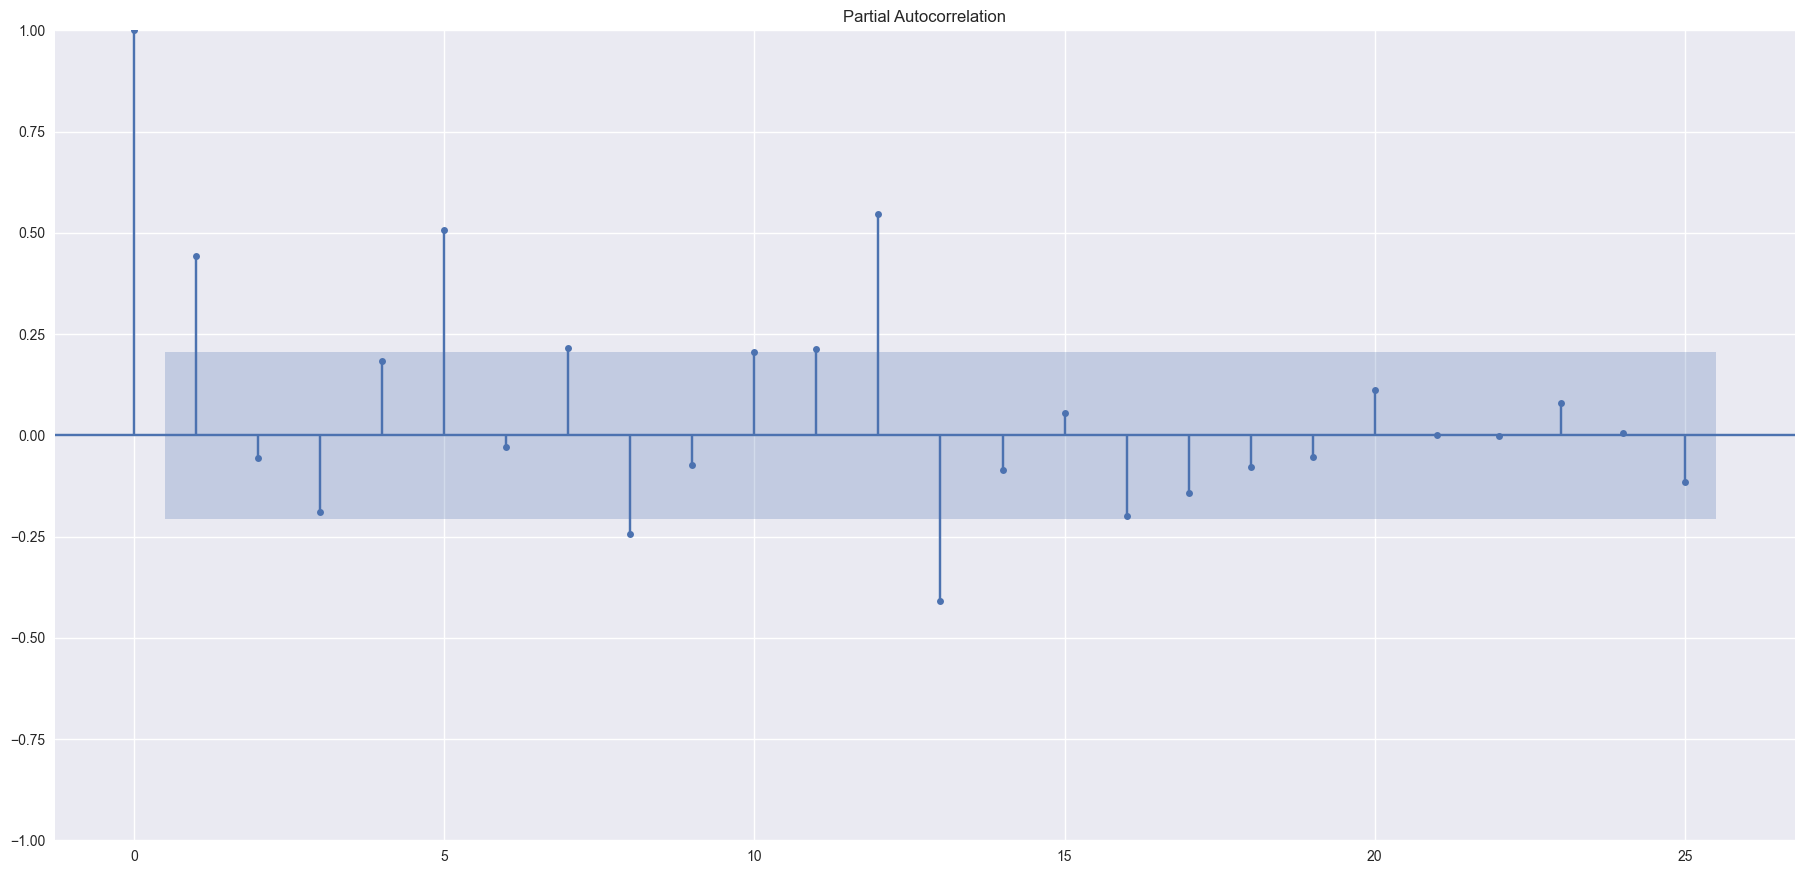

In [42]:
plot_pacf(xresiduals, lags = 25)
print()

This code analyzes the residuals from your Holt-Winters model using a Partial Autocorrelation Function (PACF) plot to further assess its performance and identify potential areas for improvement.  

*   `plot_pacf(xresiduals, lags = 25)`:
    *   `plot_pacf(...)`: This function from `statsmodels.graphics.tsaplots` creates a Partial Autocorrelation Function (PACF) plot of the residuals. The PACF plot shows the correlation between the residuals and their lagged values *after removing the effects of intermediate lags*.  This helps to identify the direct relationship between an observation and its past values, without being influenced by other intervening observations.
        *   `xresiduals`: Provides the series of residuals (calculated in the previous step) to be analyzed.
        *   `lags = 25`: Specifies the maximum number of lags to include in the PACF plot.

*   `print()`: Prints an empty line for visual separation, similar to the previous code snippet.


<Axes: xlabel='date'>

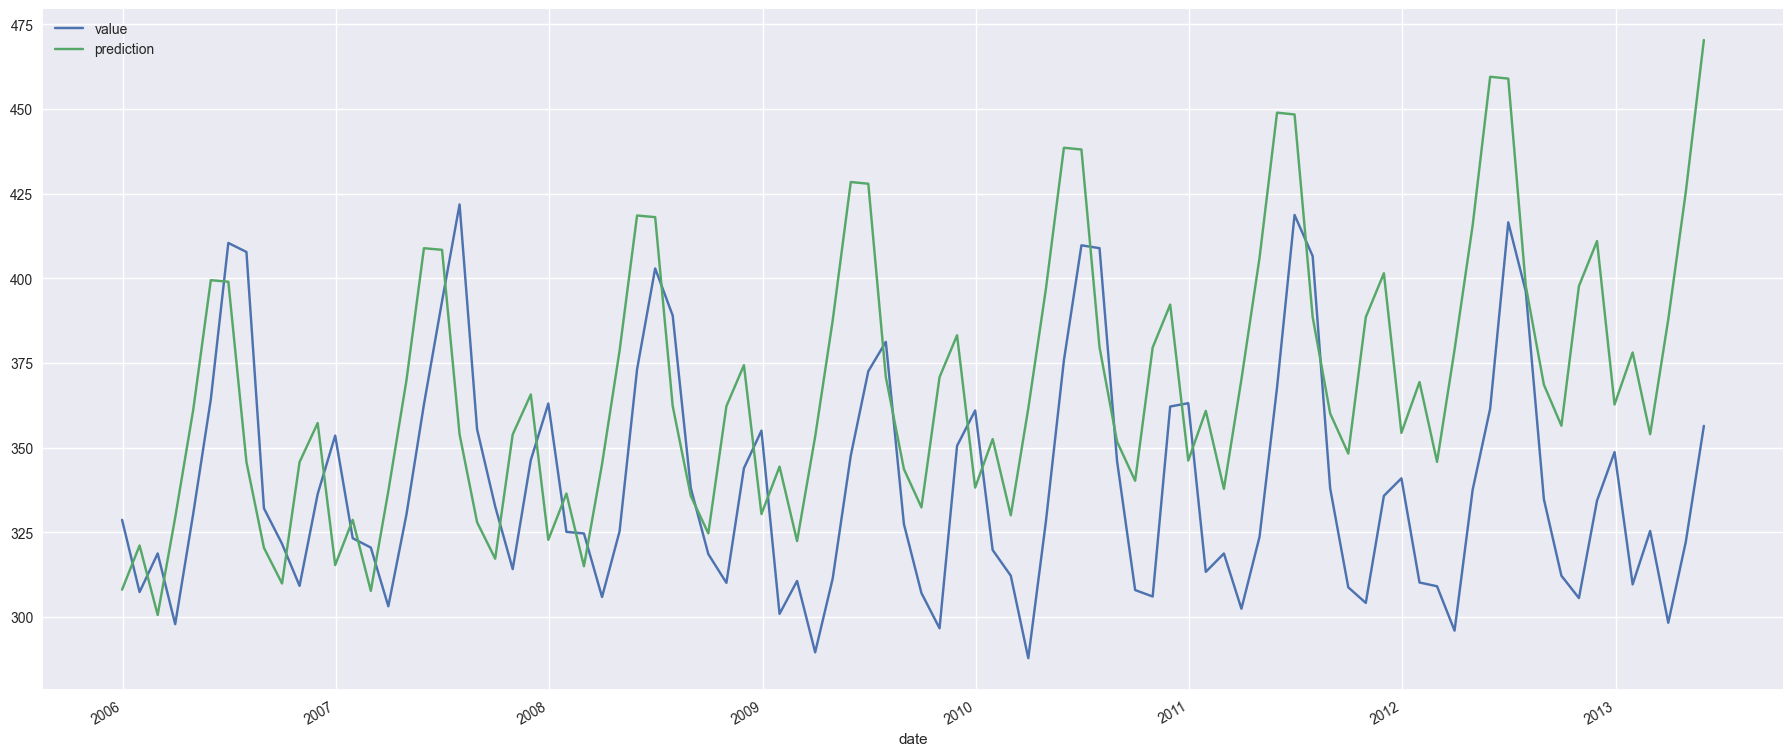

In [43]:

valid_df['prediction'] = prediction
valid_df.plot()

The code adds the forecasted values as a new column to your validation DataFrame (`valid_df`) and then creates a plot showing both the actual values and the forecasts over time. 

*   `valid_df['prediction'] = prediction`:
    *   `valid_df['prediction']`: Creates a new column named 'prediction' in the `valid_df` DataFrame.
    *   `= prediction`: Assigns the forecasted values (stored in the `prediction` variable) to this new column.  Now, your validation DataFrame contains both the actual observed values ('value') and the corresponding predicted values ('prediction').

*   `valid_df.plot()`:
    *   `valid_df.plot()`: Creates a line plot of all numerical columns in the `valid_df` DataFrame. Since you have 'value' (the actual data) and 'prediction' (the forecasted data), Pandas will create a plot with two lines: one for the actual values and one for the predicted values.  The index of the DataFrame (which is the date/time) will be used as the x-axis.


In [44]:
forecast_metrics(valid_df['value'], valid_df['prediction'])

{'MAE': 40.46, 'RMSE': 48.52}